In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import sys
import os
import math
import copy
from collections import OrderedDict, defaultdict

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import pymaster as nmt
import pyccl as ccl
from tqdm.notebook import tqdm
from scipy.integrate import simps

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH
from utils import get_config, get_normalized_dist, save_correlations, read_fits_to_pandas, read_correlations, get_jackknife_masks, get_config, read_covariances, get_masked_map
from data_lotss import get_lotss_redshift_distribution, get_skads_sim_data, read_lotss_noise_weight_map, get_lotss_data, get_lotss_map, get_lotss_redshift_distribution, get_biggest_optical_region, get_redshift_distributions, LOTSS_JACKKNIFE_REGIONS
from experiment import Experiment
from reports import show_mcmc_report
from plotting import my_mollview, plot_correlation_matrix, plot_correlation, plot_correlation_comparison, plot_jackknife_regions, plot_covariance_matrices
from redshift import plot_redshift_distributions, get_powerlaw_redshift, make_tomographer_fit

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)

/tmp/ipykernel_3746977/3596750904.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [4]:
%matplotlib inline

In [5]:
data_name = 'LoTSS_DR2'

# Run experiment

In [9]:
config = get_config(data_name)
display(config.__dict__)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': False,
 'is_mock': False,
 'lss_mask_name': 'mask_inner',
 'nside': 512,
 'flux_min_cut': 1.5,
 'signal_to_noise': 7.5,
 'read_correlations_flag': False,
 'read_covariance_flag': True,
 'error_method': 'jackknife',
 'l_range': {'gg': [52, 502], 'gk': [52, 802], 'gt': [2, 50]},
 'ells_per_bin': {'gg': 50, 'gk': 50, 'gt': 16},
 'dn_dz_model': 'power_law',
 'z_0': 0.1,
 'gamma': 2.0,
 'z_tail': 1.0,
 'A': 0.1,
 'B': 0.5,
 'C': 0.25,
 'A_z': 1.0,
 'z_sfg': 0.05,
 'a': 5.0,
 'r': 0.2,
 'n': 100000,
 'a_2': 6.0,
 'r_2': 0.08,
 'offset': 1.4,
 'A_z_tail': 1,
 'bias_model': 'scaled',
 'b_g': 2.0,
 'b_g_scaled': 1.5,
 'b_a': 0.5,
 'b_b': 1.0,
 'b_0': 1.5,
 'b_1': 1.0,
 'b_2': 0.1,
 'b_eff_tomo': 2.5,
 'A_sn': 1.1,
 'cosmology_name': 'planck',
 'matter_power_spectrum': 'halofit',
 'mcmc_engine': 'emcee',
 'continue_sampling': False,
 'redshifts_to_fit': ['deep_fields'],
 'correlations_to_use': ['gg', 'gk'],
 'to_infere': ['sigma8', 'b_g_scaled', 'A

In [7]:
experiment = Experiment(config, set_data=True, set_maps=True)

31/07/2023 03:48:49 INFO: Setting data..


Original LoTSS DR2 datashape: (4396228, 26)


31/07/2023 03:48:51 INFO: Setting maps..
31/07/2023 03:48:51 INFO: NSIDE = 512
31/07/2023 03:48:51 INFO: ORDERING = RING in fits file
31/07/2023 03:48:51 INFO: INDXSCHM = IMPLICIT
31/07/2023 03:48:51 INFO: NSIDE = 256
31/07/2023 03:48:51 INFO: ORDERING = RING in fits file
31/07/2023 03:48:51 INFO: INDXSCHM = IMPLICIT


Total flux of S > 1.5 mJy: (1401782, 26)
Signal to noise > 7.5: (1136219, 26)
Masking: 897649.0


31/07/2023 03:48:52 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
31/07/2023 03:48:52 INFO: -> fwhm is 0.000000 arcmin
31/07/2023 03:48:52 INFO: NSIDE = 2048
31/07/2023 03:48:52 INFO: ORDERING = RING in fits file
31/07/2023 03:48:52 INFO: INDXSCHM = IMPLICIT
31/07/2023 03:49:04 INFO: NSIDE = 2048
31/07/2023 03:49:04 INFO: ORDERING = NESTED in fits file
31/07/2023 03:49:04 INFO: No INDXSCHM keyword in header file: assume IMPLICIT
31/07/2023 03:49:04 INFO: INDXSCHM = IMPLICIT
31/07/2023 03:49:06 INFO: Ordering converted to RING
31/07/2023 03:49:06 INFO: NSIDE = 2048
31/07/2023 03:49:06 INFO: ORDERING = NESTED in fits file
31/07/2023 03:49:06 INFO: No INDXSCHM keyword in header file: assume IMPLICIT
31/07/2023 03:49:06 INFO: INDXSCHM = IMPLICIT
31/07/2023 03:49:07 INFO: Ordering converted to RING


In [8]:
experiment.set_correlations()

31/07/2023 03:49:30 INFO: Setting data correlations..
31/07/2023 03:49:33 INFO: Setting theory correlations..
31/07/2023 03:49:33 INFO: Setting covariance..


In [9]:
experibment.noise_curves['gg']

1.470158180162995e-06

In [11]:
experiment.noise_decoupled['gg']

array([1.47279610e-06, 1.46188698e-06, 1.46241214e-06, 1.46252433e-06,
       1.46266025e-06, 1.46280931e-06, 1.46297498e-06, 1.46315784e-06,
       1.46336022e-06, 1.46358239e-06, 1.46382726e-06, 1.46409598e-06,
       1.46439352e-06, 1.46471854e-06, 1.46507224e-06, 1.46545604e-06,
       1.46587180e-06, 1.46632305e-06, 1.46681434e-06, 1.46734995e-06,
       1.46794574e-06, 1.46861205e-06, 1.46938084e-06, 1.47028999e-06,
       1.47138330e-06, 1.47279592e-06, 1.47472268e-06, 1.47773285e-06,
       1.48103026e-06, 1.55876450e-06])

In [18]:
experiment.workspaces['gg'].couple_cell([[experiment.noise_curves['gg']] * (3 * experiment.config.nside)])

array([[7.20962149e-08, 7.20960976e-08, 7.20960524e-08, ...,
        5.48492759e-08, 4.99815710e-08, 4.15577808e-08]])

In [ ]:
save_correlations(experiment)

In [16]:
# Save data
experiment.data['g'][['RA', 'DEC']].to_csv(os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer/LoTSS_DR2_v100.srl_1.5mJy_7.5SNR.csv'))

In [8]:
# Save mask
r = hp.Rotator(coord=['C', 'G'])
tmp = experiment.masks['g'].filled(0)
tmp = r.rotate_map_pixel(tmp)
cfg = experiment.config
filename = 'mask_weight_{}mJy_{}SNR_inner_galactic_nside={}.fits'.format(cfg.flux_min_cut, cfg.signal_to_noise, cfg.nside)
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer', filename)
hp.fitsfunc.write_map(filepath, tmp, overwrite=True)
print('Mask saved to: {}'.format(filepath))

02/03/2022 14:57:27 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/mask_weight_1.5mJy_7.5SNR_inner_galactic_nside=512.fits


In [18]:
# Save map
r = hp.Rotator(coord=['C', 'G'])
tmp = experiment.processed_maps['g'].filled(0)
tmp = r.rotate_map_pixel(tmp)
cfg = experiment.config
filename = 'map_overdensity_{}mJy_{}SNR_inner_galactic_nside={}.fits'.format(cfg.flux_min_cut, cfg.signal_to_noise, cfg.nside)
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/for_tomographer', filename)
hp.fitsfunc.write_map(filepath, tmp, overwrite=True)
print('Map saved to: {}'.format(filepath))

02/03/2022 15:32:38 WARNING: setting the output map dtype to [dtype('float64')]


Map saved to: /home/snakoneczny/data/LoTSS/DR2/for_tomographer/map_overdensity_1.5mJy_7.5SNR_inner_galactic_nside=512.fits


In [37]:
# Save masks
from data_lotss import get_dr2_inner_regions

for nside in [128, 256, 512, 1024]:
    mask = get_dr2_inner_regions(nside)

    # For tomographer, add rotation and save to different folder, and file name extended with galactic
    # r = hp.Rotator(coord=['C', 'G'])
    # tmp = r.rotate_map_pixel(mask)

    filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/masks/mask_inner', 'mask_inner_nside={}.fits'.format(nside))
    hp.fitsfunc.write_map(filepath, mask, overwrite=True)
    print('Mask saved to: {}'.format(filepath))

100%|████████████████████████████████████████████████████| 196608/196608 [00:01<00:00, 130612.55it/s]
30/04/2023 05:29:44 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/sjnakoneczny/data/LoTSS/DR2/masks/mask_inner/mask_inner_nside=128.fits


100%|████████████████████████████████████████████████████| 786432/786432 [00:06<00:00, 129922.64it/s]
30/04/2023 05:29:50 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/sjnakoneczny/data/LoTSS/DR2/masks/mask_inner/mask_inner_nside=256.fits


100%|██████████████████████████████████████████████████| 3145728/3145728 [00:24<00:00, 129161.61it/s]
30/04/2023 05:30:15 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/sjnakoneczny/data/LoTSS/DR2/masks/mask_inner/mask_inner_nside=512.fits


100%|████████████████████████████████████████████████| 12582912/12582912 [01:37<00:00, 129324.37it/s]
30/04/2023 05:31:52 WARNING: setting the output map dtype to [dtype('float64')]


Mask saved to: /home/sjnakoneczny/data/LoTSS/DR2/masks/mask_inner/mask_inner_nside=1024.fits


# Covariance matrices

In [5]:
config = get_config(data_name)
config.read_correlations_flag = True
config.read_covariance_flag = True
config.correlations_to_use = ['gg', 'gk', 'gt']

experiment = Experiment(config, set_data=False, set_maps=False)
experiment.set_correlations()

21/09/2022 13:34:54 INFO: Setting data correlations..
21/09/2022 13:34:54 INFO: Setting theory correlations..
21/09/2022 13:34:55 INFO: Setting covariance..


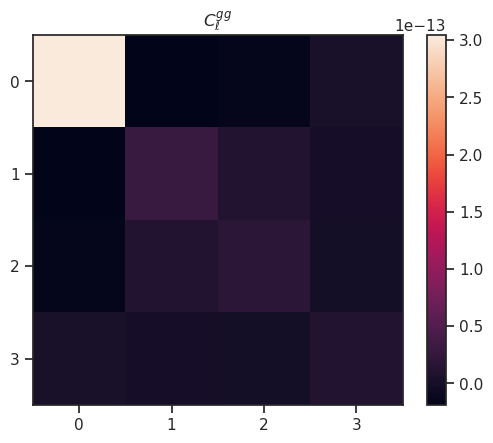

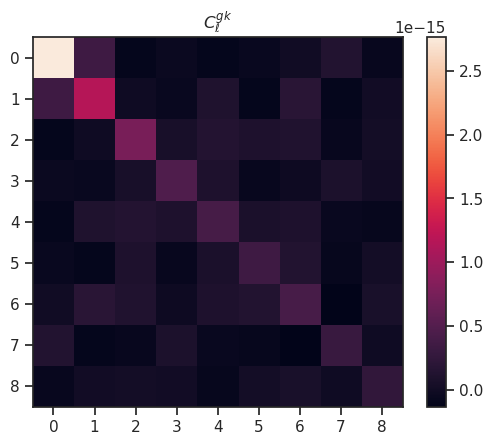

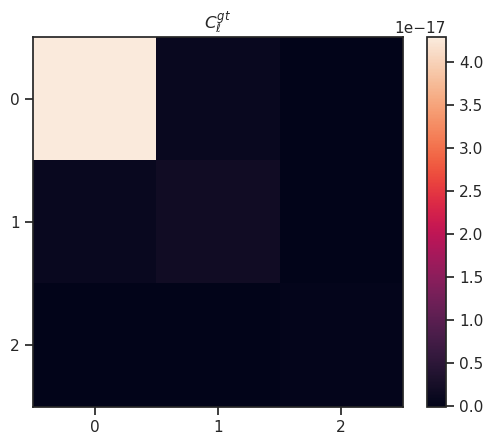

In [13]:
plot_covariance_matrices(experiment)

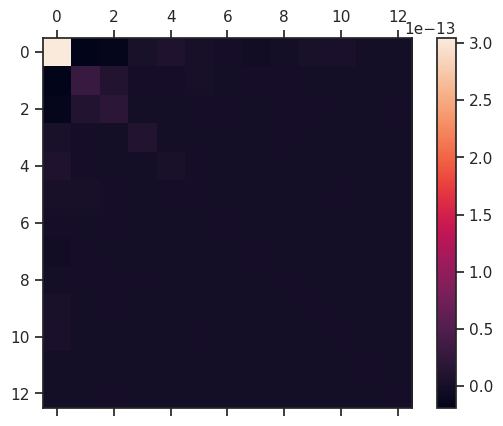

In [12]:
n_bins = sum([experiment.n_ells[corr_symbol] for corr_symbol in experiment.config.correlations_to_use])
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(experiment.inference_covariance[:n_bins, :n_bins], interpolation=None)
fig.colorbar(cax)

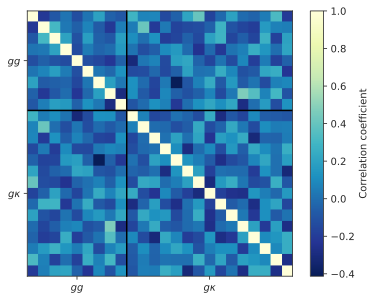

In [10]:
# 1.5mJy 7.5 SNR
plot_correlation_matrix(experiment)

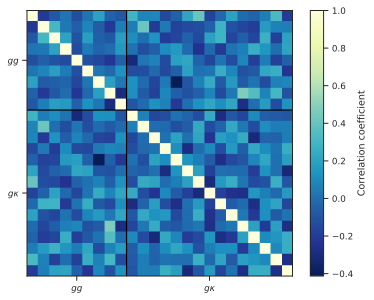

In [9]:
# 1.5mJy 7.5 SNR
plot_correlation_matrix(experiment)

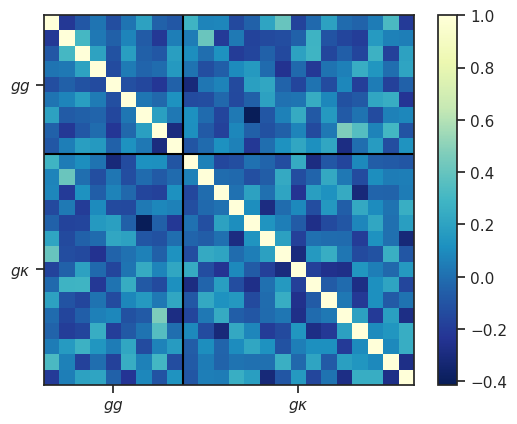

In [9]:
# 1.5mJy 7.5 SNR
plot_correlation_matrix(experiment)

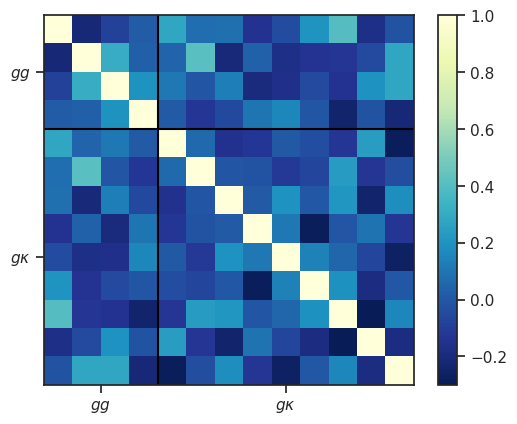

In [38]:
# 1.5mJy 7.5 SNR
plot_correlation_matrix(experiment)

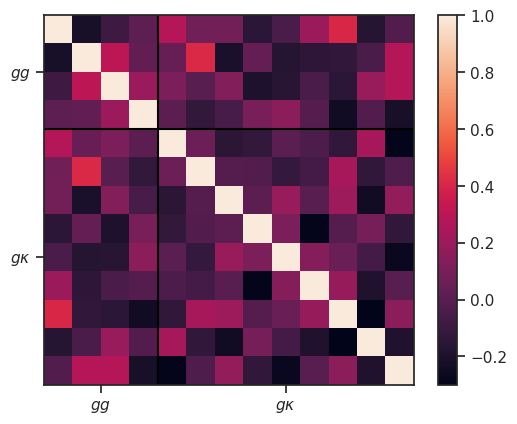

In [9]:
# 1.5mJy 7.5 SNR
plot_correlation_matrix(experiment)

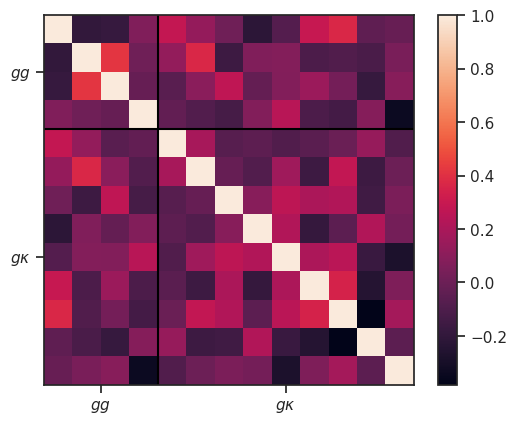

In [11]:
# 2.0mJy 5.0 SNR
plot_correlation_matrix(experiment)

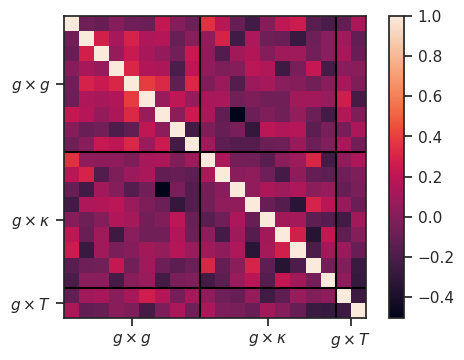

In [8]:
plot_correlation_matrix(experiment)

21/09/2022 13:36:51 INFO: Setting data correlations..
21/09/2022 13:36:51 INFO: Setting theory correlations..
21/09/2022 13:36:51 INFO: Setting covariance..


1.0 mJy, 5.0 SNR


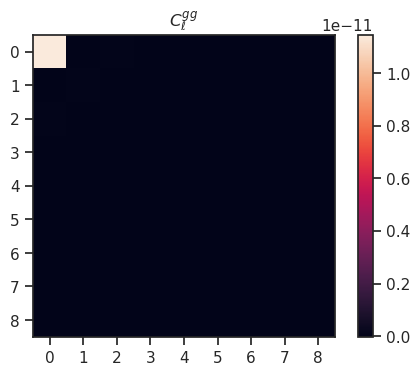

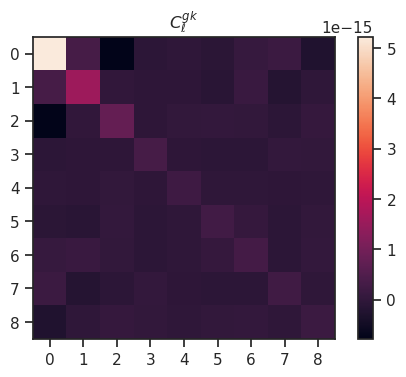

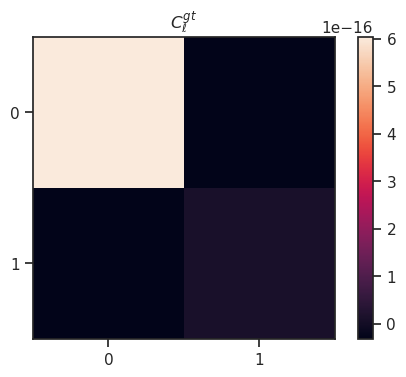

21/09/2022 13:36:52 INFO: Setting data correlations..
21/09/2022 13:36:52 INFO: Setting theory correlations..
21/09/2022 13:36:52 INFO: Setting covariance..


1.0 mJy, 7.5 SNR


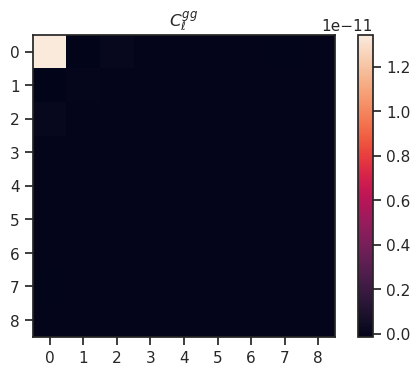

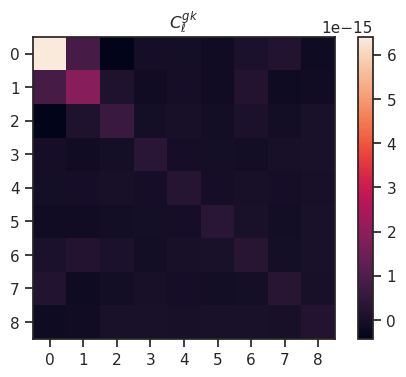

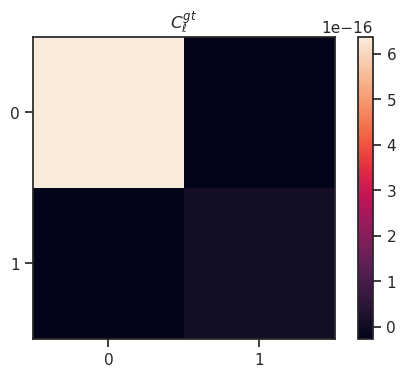

21/09/2022 13:36:53 INFO: Setting data correlations..
21/09/2022 13:36:53 INFO: Setting theory correlations..
21/09/2022 13:36:53 INFO: Setting covariance..


1.5 mJy, 5.0 SNR


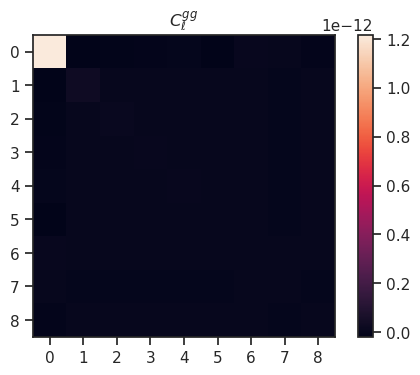

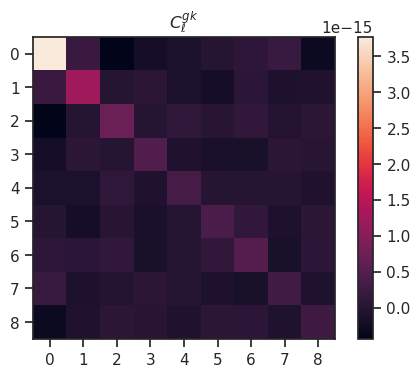

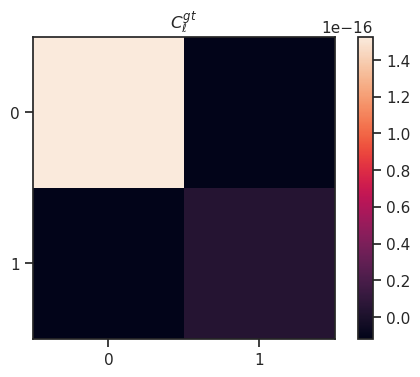

21/09/2022 13:36:53 INFO: Setting data correlations..
21/09/2022 13:36:53 INFO: Setting theory correlations..
21/09/2022 13:36:54 INFO: Setting covariance..


1.5 mJy, 7.5 SNR


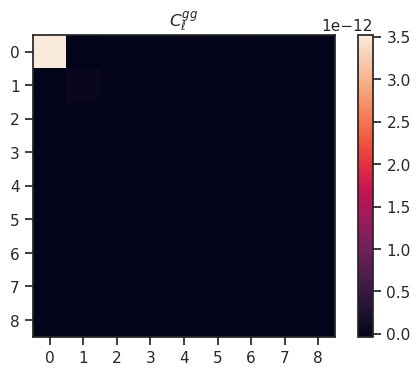

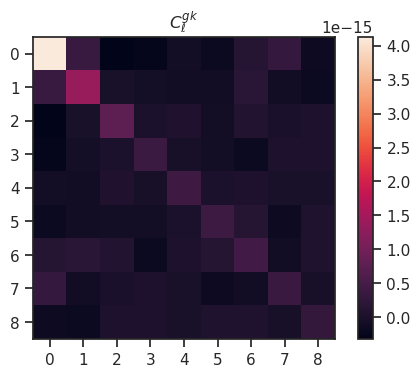

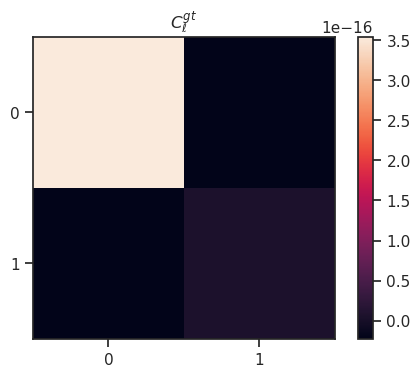

21/09/2022 13:36:54 INFO: Setting data correlations..
21/09/2022 13:36:54 INFO: Setting theory correlations..
21/09/2022 13:36:54 INFO: Setting covariance..


2.0 mJy, 5.0 SNR


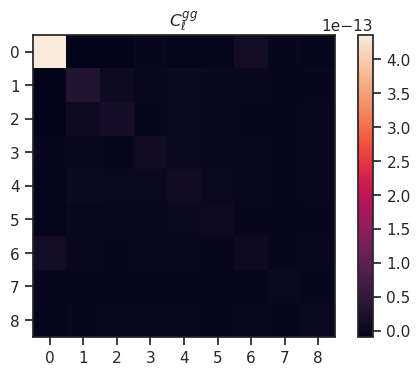

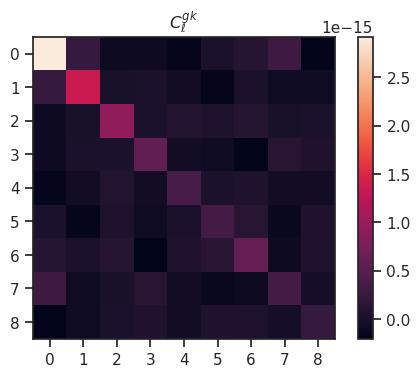

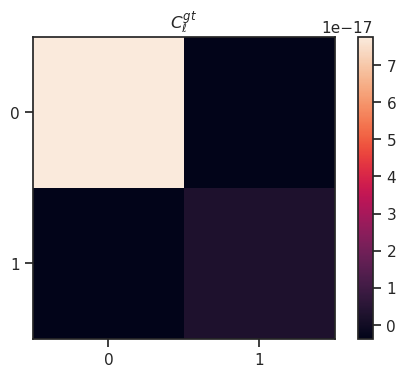

21/09/2022 13:36:55 INFO: Setting data correlations..
21/09/2022 13:36:55 INFO: Setting theory correlations..
21/09/2022 13:36:55 INFO: Setting covariance..


2.0 mJy, 7.5 SNR


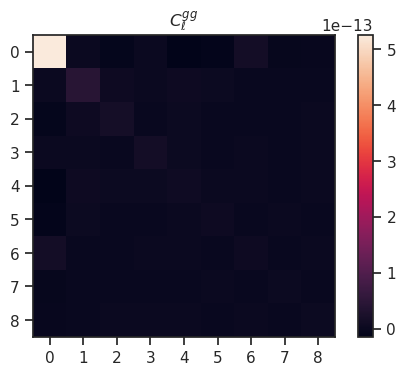

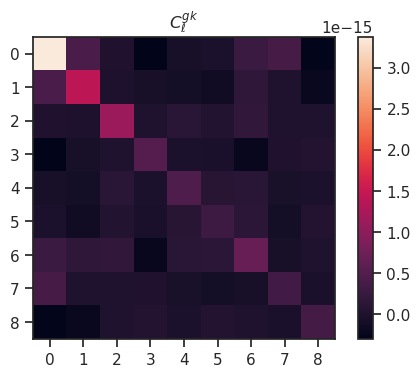

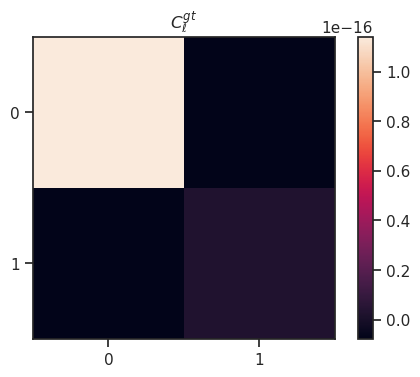

In [8]:
# Flux and SNR cuts comparison
to_process = [
    (1.0, 5.0),
    (1.0, 7.5),
    (1.5, 5.0),
    (1.5, 7.5),
    (2.0, 5.0),
    (2.0, 7.5),
]

for flux_cut, snr_cut in to_process:
    config = get_config(data_name)
    config.flux_min_cut = flux_cut
    config.signal_to_noise = snr_cut
    config.read_correlations_flag = True
    config.read_covariance_flag = True

    experiment = Experiment(config, set_data=False, set_maps=False)
    experiment.set_correlations()
    print('{} mJy, {} SNR'.format(flux_cut, snr_cut))
    plot_covariance_matrices(experiment)

# Chosing ell range

In [24]:
import pyccl

z = 0.82
ells = [50, 250, 500, 800]

with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
    cosmology_params = yaml.full_load(cosmology_file)['planck']
cosmology_params['matter_power_spectrum'] = 'halofit'

h = cosmology_params['h']

cosmology = ccl.Cosmology(**cosmology_params)

for ell in ells:
    theta = 180 / ell
    chi = pyccl.comoving_radial_distance(cosmo, 1. / (1 + z))
    rc = chi * theta / 180
    k = 1 / rc
    print('ell: {}, theta: {:.2f} degrees, k: {:.2f} Mpc ^ -1, k: {:.2f} h Mpc ^ -1'.format(ell, theta, k, k / h))

ell: 50, theta: 3.60 degrees, k: 0.02 Mpc ^ -1, k: 0.01 h ^ -1 Mpc ^ -1
ell: 250, theta: 0.72 degrees, k: 0.09 Mpc ^ -1, k: 0.06 h ^ -1 Mpc ^ -1
ell: 500, theta: 0.36 degrees, k: 0.18 Mpc ^ -1, k: 0.12 h ^ -1 Mpc ^ -1
ell: 800, theta: 0.23 degrees, k: 0.28 Mpc ^ -1, k: 0.19 h ^ -1 Mpc ^ -1


In [11]:
flux_cut = 1.5
snr_cut = 7.5

params_halofit = {
    'b_g_scaled': 1.41,
    'A_sn': 1.01,
    'z_sfg': 0.05,
    'a': 4.93,
    'r': 0.19,
}

params_linear = {
    'b_g_scaled': 1.54,
    'A_sn': 1.19,
    'z_sfg': 0.05,
    'a': 4.93,
    'r': 0.20,
}

In [12]:
def plot_theory_correlation(matter_power_spectrum, corr_a='g', corr_b='g', color=None, linestyle=None, label=None):    
    ell_arr = np.arange(2, 3 * 512)
    
    with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
        cosmology_params = yaml.full_load(cosmology_file)['planck']
    cosmology_params['matter_power_spectrum'] = matter_power_spectrum
    cosmology = ccl.Cosmology(**cosmology_params)

    z_arr, n_arr = get_lotss_redshift_distribution(model='power_law', z_max=6, normalize=False, z_sfg=z_sfg, a=a, r=r)

    bias_arr = b_g_scaled * np.ones(len(z_arr))
    bias_arr = bias_arr / ccl.growth_factor(cosmology, 1. / (1. + z_arr))

    tracers_dict = {
        'g': ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z_arr, n_arr), bias=(z_arr, bias_arr)),
        'k': ccl.CMBLensingTracer(cosmology, 1091),
    }
    correlation = ccl.angular_cl(cosmology, tracers_dict[corr_a], tracers_dict[corr_b], ell_arr)

    # A_sn
    if corr_a == 'g' and corr_b == 'g':
        correlation += (A_sn - 1) * experiment.noise_decoupled['gg'][0]

    plt.plot(ell_arr, correlation, color=color, linestyle=linestyle, label=label)

    correlation_symbol = '{}{}'.format(corr_a, corr_b)
    if correlation_symbol == 'gg':
        plt.ylim(ymin=3*1e-8, ymax=6*1e-5)
    elif correlation_symbol == 'gk':
        plt.ylim(ymin=2*1e-9, ymax=2*1e-6)
    elif correlation_symbol == 'gt':
        plt.ylim(ymin=1e-12, ymax=1e-7)
        plt.xlim(xmax=config.l_range['gt'][1] * 3) 

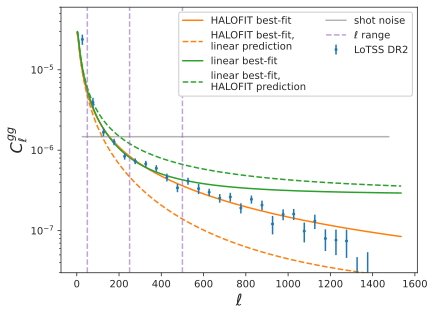

In [13]:
# Theoretical models
locals().update(params_halofit)
plot_theory_correlation('halofit', corr_a='g', corr_b='g', color='C1', linestyle=None, label='HALOFIT best-fit')
plot_theory_correlation('linear', corr_a='g', corr_b='g', color='C1', linestyle='dashed', label='HALOFIT best-fit,\nlinear prediction')

locals().update(params_linear)
plot_theory_correlation('linear', corr_a='g', corr_b='g', color='C2', linestyle=None, label='linear best-fit')
plot_theory_correlation('halofit', corr_a='g', corr_b='g', color='C2', linestyle='dashed', label='linear best-fit,\nHALOFIT prediction')

# Data
correlation_symbol = 'gg'
y_err = experiment.errors['jackknife'][correlation_symbol]
ell_arr = experiment.binnings[correlation_symbol].get_effective_ells()
noise = experiment.noise_decoupled[correlation_symbol]
correlation_dict = experiment.data_correlations
data_to_plot = correlation_dict[correlation_symbol] - noise
plt.errorbar(ell_arr, data_to_plot, yerr=y_err, fmt='oC0', label='LoTSS DR2', markersize=2)

# Shot noise
plt.plot(ell_arr, [noise[0]] * len(ell_arr), alpha=0.6, color='grey', markersize=2, label='shot noise')

# ell range
plt.axvline(50, color='C4', linestyle='dashed', alpha=0.6, label='$\ell$ range')
plt.axvline(250, color='C4', linestyle='dashed', alpha=0.6)
plt.axvline(500, color='C4', linestyle='dashed', alpha=0.6)

plt.legend(loc='upper right', ncol=2, framealpha=1.0)
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{{{}}}$'.format('gg'), fontsize=16)
plt.show()

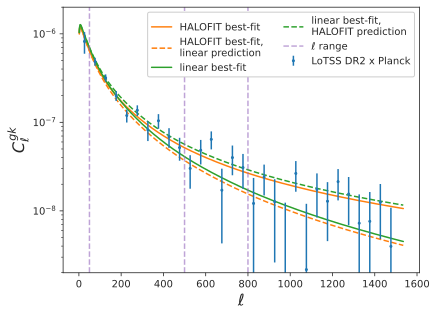

In [14]:
# Theoretical models
locals().update(params_halofit)
plot_theory_correlation('halofit', corr_a='g', corr_b='k', color='C1', linestyle=None, label='HALOFIT best-fit')
plot_theory_correlation('linear', corr_a='g', corr_b='k', color='C1', linestyle='dashed', label='HALOFIT best-fit,\nlinear prediction')

locals().update(params_linear)
plot_theory_correlation('linear', corr_a='g', corr_b='k', color='C2', linestyle=None, label='linear best-fit')
plot_theory_correlation('halofit', corr_a='g', corr_b='k', color='C2', linestyle='dashed', label='linear best-fit,\nHALOFIT prediction')

# Data
correlation_symbol = 'gk'
y_err = experiment.errors['jackknife'][correlation_symbol]
ell_arr = experiment.binnings[correlation_symbol].get_effective_ells()
correlation_dict = experiment.data_correlations
data_to_plot = correlation_dict[correlation_symbol]
plt.errorbar(ell_arr, data_to_plot, yerr=y_err, fmt='oC0', label='LoTSS DR2 x Planck', markersize=2)

# ell range
plt.axvline(50, label='$\ell$ range', color='C4', linestyle='dashed', alpha=0.6)
plt.axvline(500, color='C4', linestyle='dashed', alpha=0.6)
plt.axvline(800, color='C4', linestyle='dashed', alpha=0.6)

plt.legend(loc='upper right', ncol=2, framealpha=1.0)
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{{{}}}$'.format('gk'), fontsize=16)
plt.show()

In [58]:
def plot_b_nz_vs_k():
    with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
        cosmology_params = yaml.full_load(cosmology_file)['planck']
    cosmology_params['matter_power_spectrum'] = 'halofit'
    cosmology = ccl.Cosmology(**cosmology_params)
    
    flux_cut = 1.5
    z_arr, n_arr = get_lotss_redshift_distribution(flux_cut=1.5, model='deep_fields', z_max=6, normalize=False)
    
    b_g_scaled = 1.4
    bias_arr = b_g_scaled * np.ones(len(z_arr))
    bias_arr = bias_arr / ccl.growth_factor(cosmology, 1. / (1. + z_arr))
    
    chi = ccl.comoving_radial_distance(cosmology, 1. / (1. + z_arr))

    for ell in [200, 500, 800, 1100]:
        k = (ell + 0.5) / chi
        plt.plot(k, bias_arr * n_arr, label=r'$\ell = {}$'.format(ell))
    
    ax = plt.gca()
    ax.axvspan(0.1, 0.2, alpha=.2, color='blue')
    ax.axvspan(0.0, 0.1, alpha=.3, color='blue')

    plt.legend()
    plt.xscale('log')
    plt.xlabel('k')
    plt.ylabel('b * N(z)')
    plt.show()

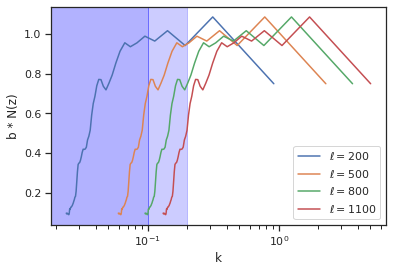

In [14]:
%matplotlib inline

plot_b_nz_vs_k()

# NSIDE

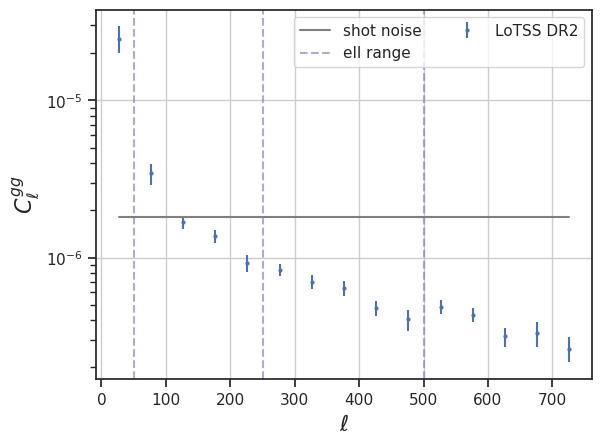

In [9]:
# nside = 256

# Data
correlation_symbol = 'gg'
y_err = experiment.errors['jackknife'][correlation_symbol]
ell_arr = experiment.binnings[correlation_symbol].get_effective_ells()
noise = experiment.noise_decoupled[correlation_symbol]
correlation_dict = experiment.data_correlations
data_to_plot = correlation_dict[correlation_symbol] - noise
plt.errorbar(ell_arr, data_to_plot, yerr=y_err, fmt='oC0', label='LoTSS DR2', markersize=2)

# Shot noise
plt.plot(ell_arr, [noise[0]] * len(ell_arr), color='grey', label='shot noise', markersize=2)

# ell range
plt.axvline(50, label='ell range', color='C4', linestyle='dashed', alpha=0.6)
plt.axvline(250, color='C4', linestyle='dashed', alpha=0.6)
plt.axvline(500, color='C4', linestyle='dashed', alpha=0.6)

plt.legend(loc='upper right', ncol=2)
plt.yscale('log')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell^{{{}}}$'.format('gg'), fontsize=16)
plt.grid()
plt.show()

# Theoretical models

## z-tail and cosmology

In [5]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': True,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 1,
 'signal_to_noise': 3,
 'new_z_dist': True,
 'z_tail': 1.1,
 'z_sfg': 0.24,
 'z_agn': 1.5,
 'r': 0.007,
 'scale_bias': True,
 'bias': 1.2,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [2, 120], 'gt': [2, 120]},
 'ells_per_bin': {'gg': 16, 'gt': 16},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [5]:
to_plot_tuples = [('bias', np.arange(0.8, 2.0, 0.1)), ('z_tail', np.arange(0.8, 2.0, 0.1)), ('Omega_c_b_frac', np.arange(0.5, 1.6, 0.1)), ('Omega_k', np.arange(-0.2, 0.21, 0.05))]
to_plot_correlations = ['gg', 'gk', 'gt']

config = get_config('LoTSS_DR2')
l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        omega_param = None
        if param_name in config:
            config[param_name] = param_value
        else:
            omega_param = (param_name, param_value)
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr, omega_param)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/pyccl/cls.py:46: CCLWarning: CCL does not properly use the hyperspherical Bessel functions when computing angular power spectra in non-flat cosmologies!
  category=CCLWarning)


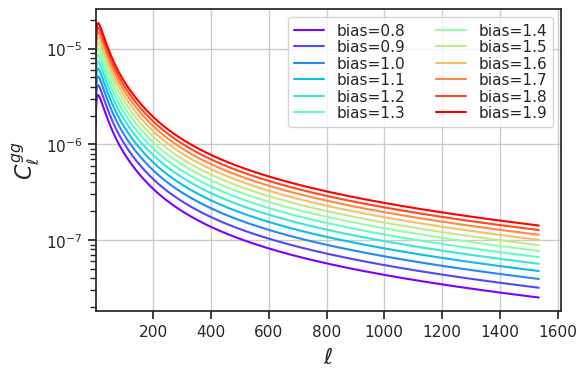

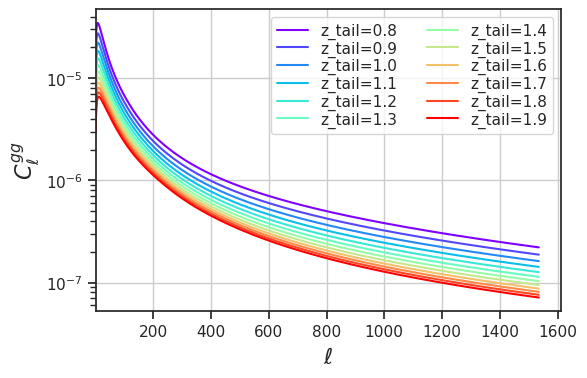

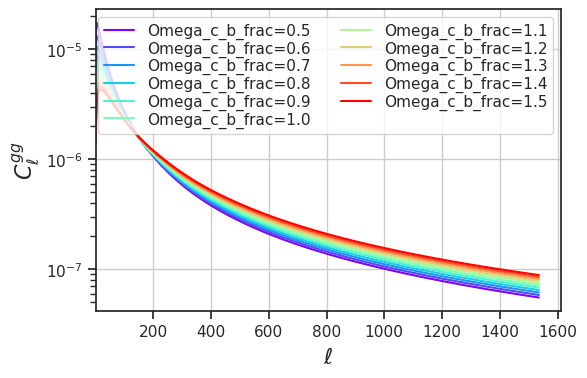

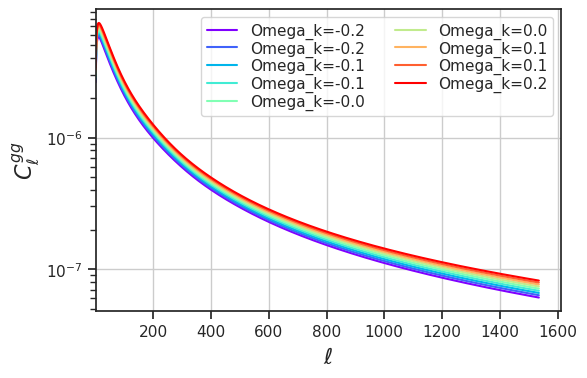

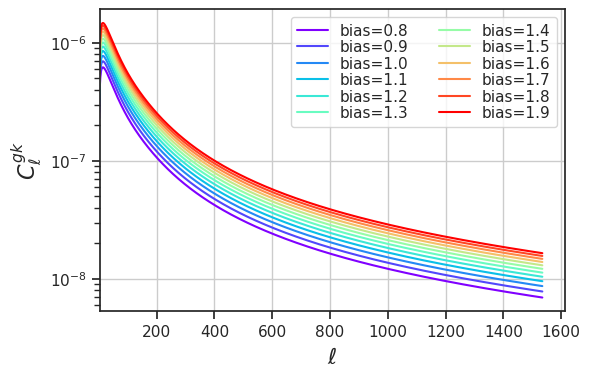

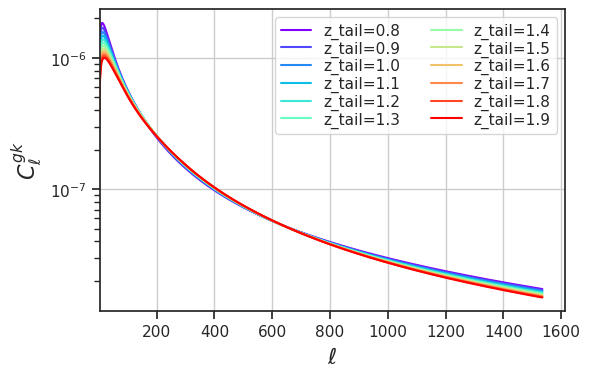

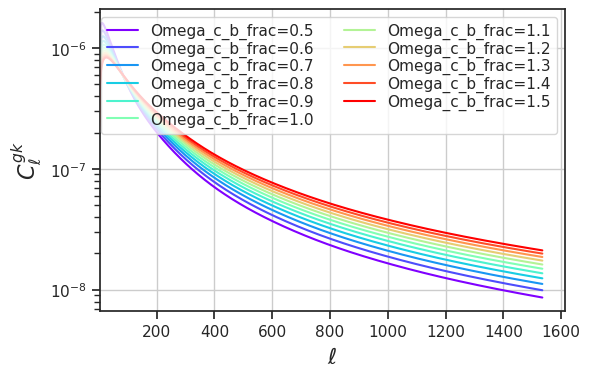

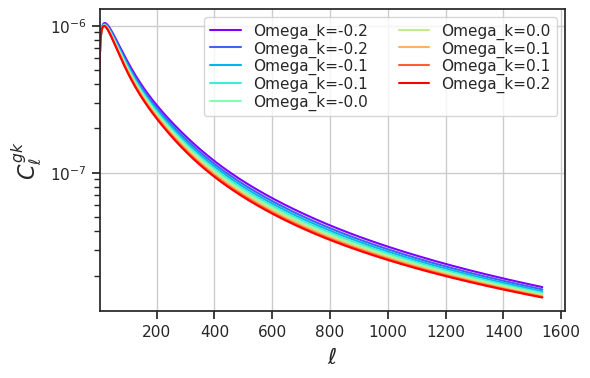

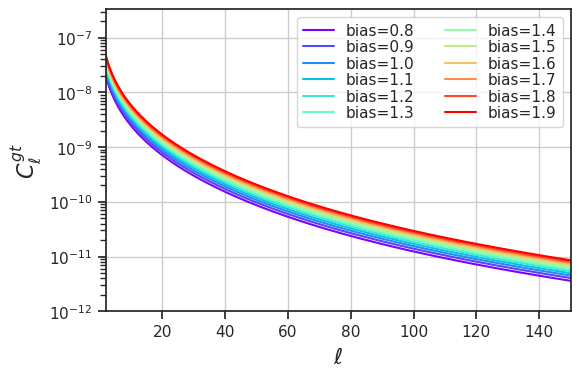

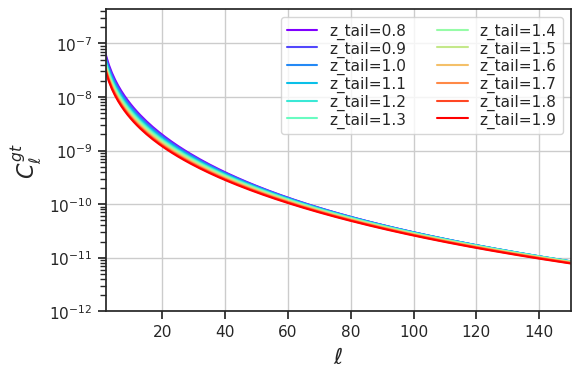

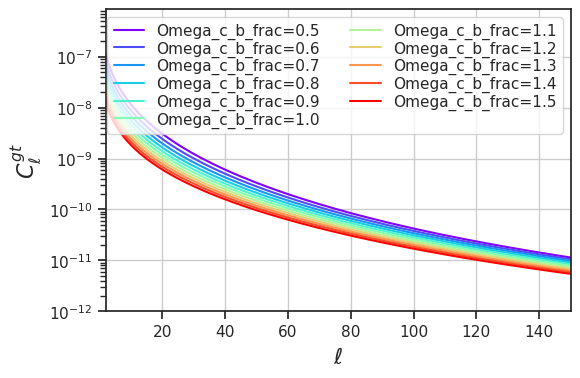

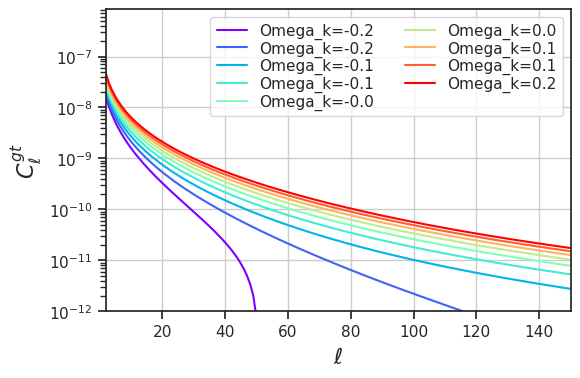

In [6]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.1f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

## AGN power law

In [4]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': True,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 2,
 'signal_to_noise': 5,
 'dn_dz_model': 'power_law',
 'z_tail': 1.3,
 'z_sfg': 0.13,
 'a': 4.66,
 'r': 0.94,
 'scale_bias': True,
 'bias': 1.4,
 'read_data_correlations_flag': False,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [52, 802], 'gk': [52, 802]},
 'ells_per_bin': {'gg': 50, 'gk': 50},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [8]:
config = get_config('LoTSS_DR2')
to_plot_correlations = ['gg', 'gk', 'gt']
to_plot_tuples = [
    ('z_sfg', np.arange(0.05, 0.21, 0.02)),
    ('a', np.arange(4.2, 5.0, 0.1)),
    ('r', np.arange(0.8, 1.0, 0.02)),
    ('bias', np.arange(1.0, 1.8, 0.1)),
]

l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        config[param_name] = param_value
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr)

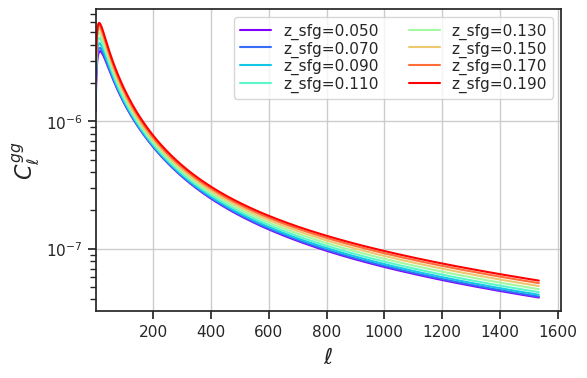

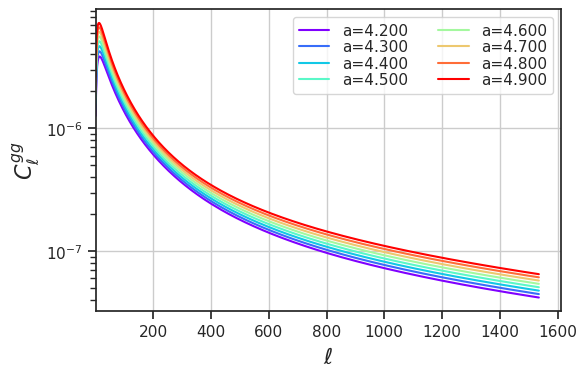

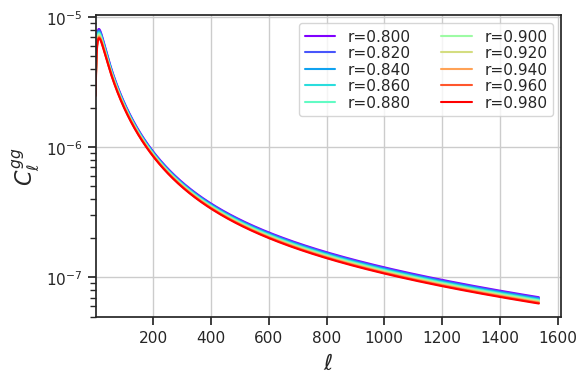

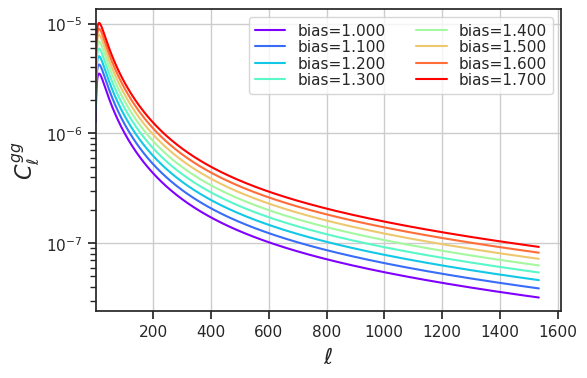

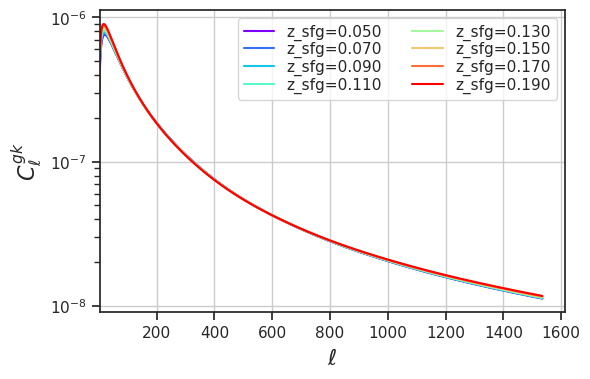

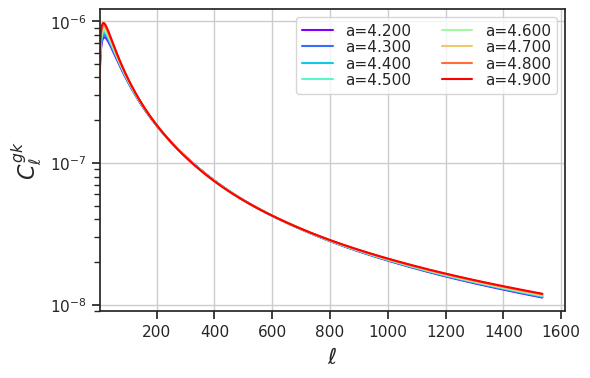

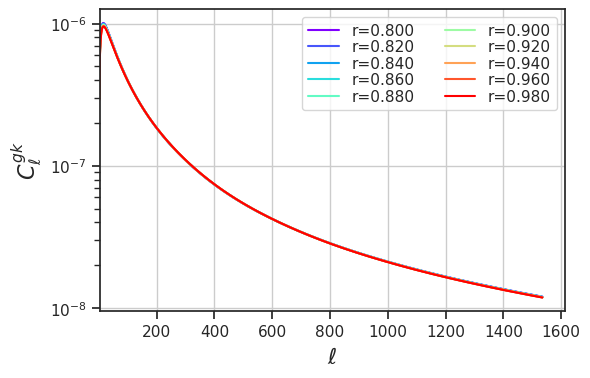

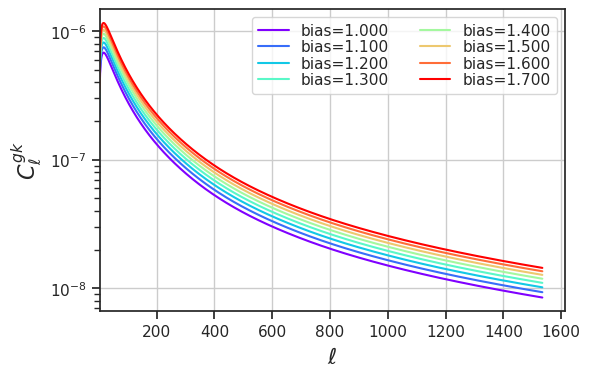

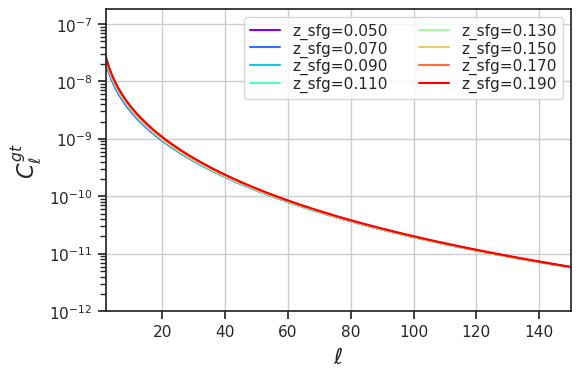

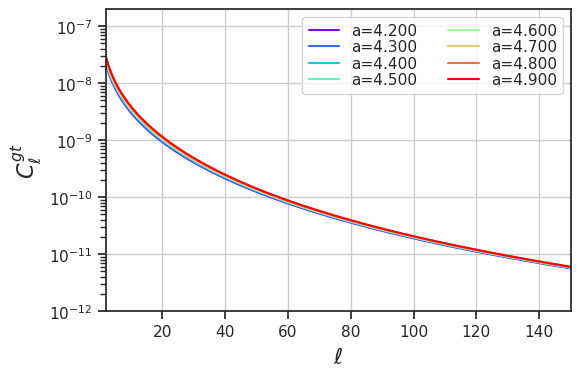

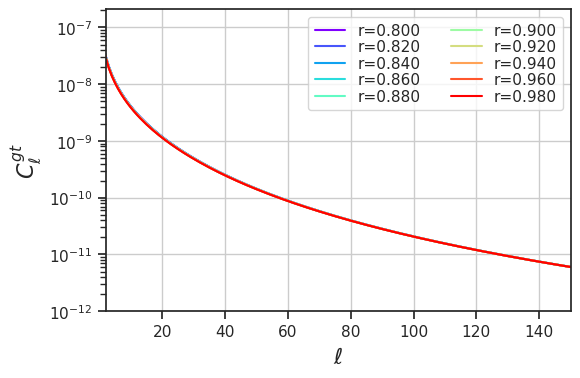

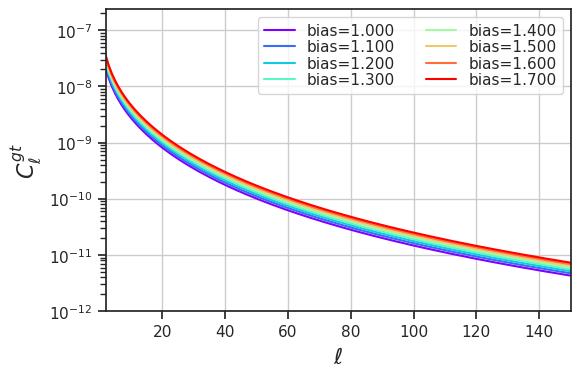

In [9]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.3f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

# Bias model

In [11]:
config = get_config('LoTSS_DR2')
display(config)

{'lss_survey_name': 'LoTSS_DR2',
 'is_optical': False,
 'lss_mask_name': 'Mask_coverage',
 'nside': 512,
 'flux_min_cut': 2,
 'signal_to_noise': 5,
 'dn_dz_model': 'power_law',
 'z_tail': 1.3,
 'z_sfg': 0.15,
 'a': 4.8,
 'r': 0.91,
 'bias_model': 'polynomial',
 'b_0_scaled': 1.4,
 'b_0': 1,
 'b_1': 1,
 'b_2': 1,
 'read_data_correlations_flag': True,
 'cosmology_name': 'planck',
 'cosmology_matter_power_spectrum': 'halofit',
 'l_range': {'gg': [52, 802], 'gk': [52, 802]},
 'ells_per_bin': {'gg': 50, 'gk': 50},
 'starting_params': {'bias': [2.1, 0.5], 'sigma8': [0.83, 0.1]},
 'n_walkers': 32,
 'max_iterations': 5000,
 'continue_sampling': False}

In [12]:
config = get_config('LoTSS_DR2')
to_plot_correlations = ['gg', 'gk', 'gt']
to_plot_tuples = [
    ('b_0', np.arange(1.0, 2.1, 0.1)),
    ('b_1', np.arange(1.0, 2.1, 0.1)),
    ('b_2', np.arange(1.0, 2.1, 0.1)),
]

l_arr = np.arange(3 * config['nside'])

correlations = {}
for to_plot_tuple in to_plot_tuples:
    param_name = to_plot_tuple[0]
    param_values = to_plot_tuple[1]

    correlations[param_name] = {}
    for param_value in param_values:
        config[param_name] = param_value
        correlations[param_name][param_value] = get_theory_correlations(config, to_plot_correlations, l_arr)

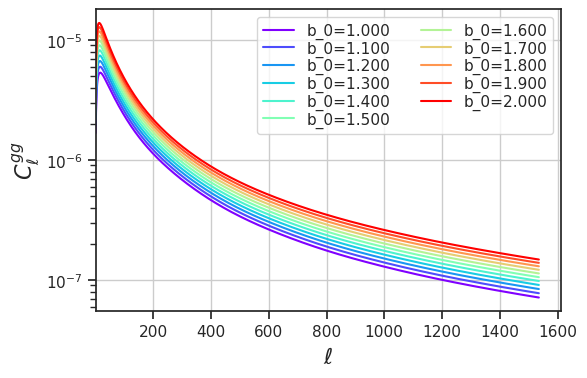

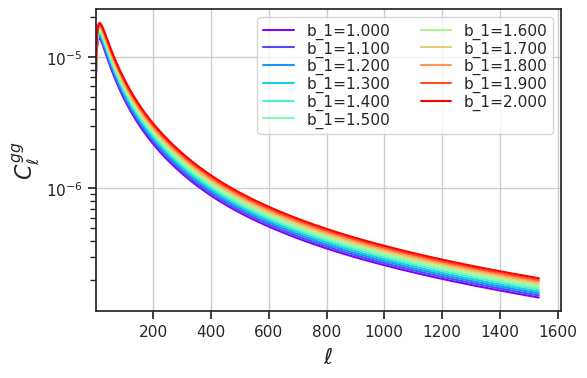

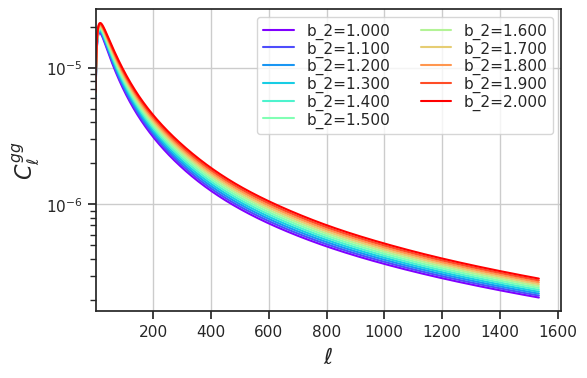

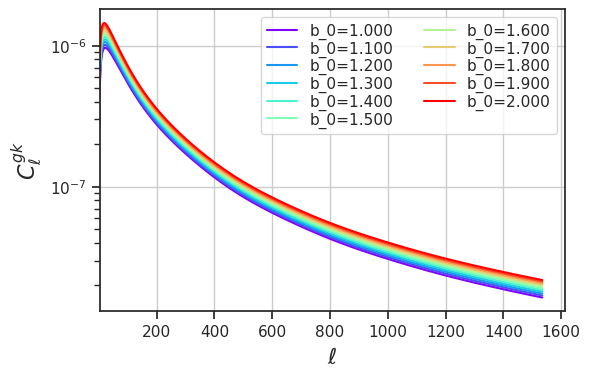

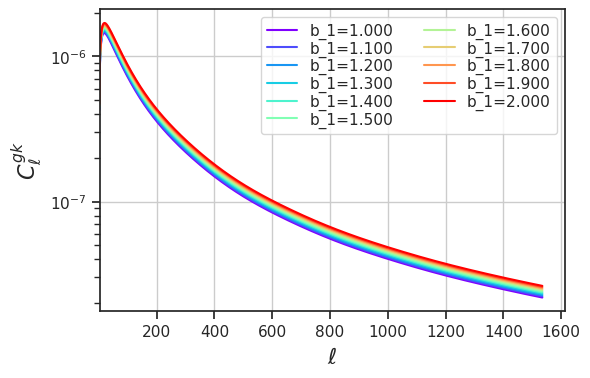

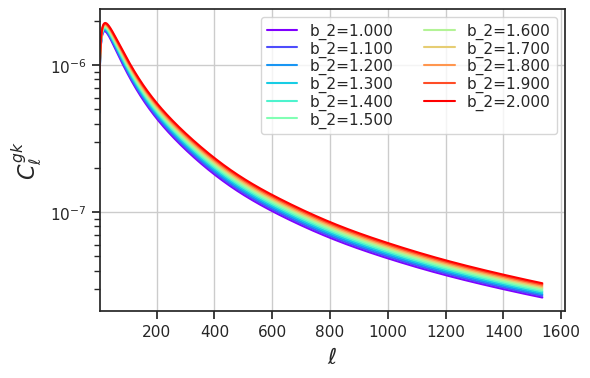

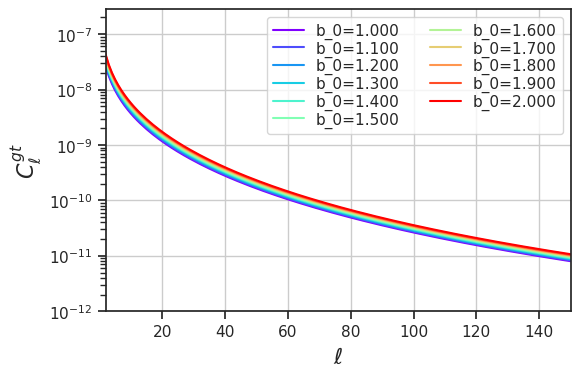

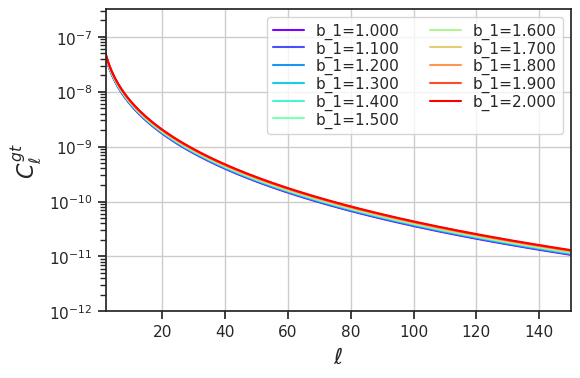

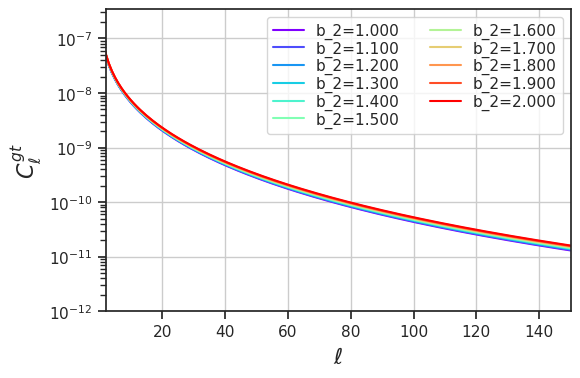

In [13]:
for correlation_symbol in to_plot_correlations:
    for param_name, param_values in to_plot_tuples:
        plt.figure()

        colors = plt.cm.rainbow(np.linspace(0, 1, len(param_values)))
        for i, param_value in enumerate(param_values):
            plt.plot(l_arr, correlations[param_name][param_value][correlation_symbol], label='{}={:.3f}'.format(param_name, param_value), c=colors[i])

        plt.xlim(xmin=2, xmax=None)
        if correlation_symbol == 'gt':
            plt.xlim(xmin=2, xmax=150)
            plt.ylim(ymin=1e-12, ymax=None)

        plt.xscale('linear')
        plt.yscale('log')
        plt.xlabel('$\\ell$', fontsize=16)
        plt.ylabel('$C_\\ell^{{{}}}$'.format(correlation_symbol), fontsize=16)
        plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
        plt.grid()
        plt.show()

# Multicomponent shot noise

In [7]:
fname = 'LoTSS_DR2/LoTSS_DR2_srl__mask_inner__{}mJy_snr={}_nside=512_gg-gk_bin=50'
for flux_cut in [1, 1.5, 2]:
    for signal_to_noise in [5, 7.5]:
        corr = read_correlations(fname.format(flux_cut, signal_to_noise))
        nl_gg_multicomp = corr['nl_gg_multicomp'][0]
        nl_gg = corr['nl_gg'][0]
        n_c = nl_gg / (nl_gg - nl_gg_multicomp)
        nl_gg_multicomponent_frac = nl_gg_multicomp / (nl_gg - nl_gg_multicomp)
        print('Flux cut = {}, signal to noise = {}, multicomp shot noise = {:.2e}, n_c = {:.2f}, fraction of the original noise {:.2f}'.format(flux_cut, signal_to_noise, nl_gg_multicomp, n_c, nl_gg_multicomponent_frac))

Flux cut = 1, signal to noise = 5, multicomp shot noise = 5.26e-08, n_c = 1.05, 0.05
Flux cut = 1, signal to noise = 7.5, multicomp shot noise = 4.90e-08, n_c = 1.04, 0.04
Flux cut = 1.5, signal to noise = 5, multicomp shot noise = 1.01e-07, n_c = 1.07, 0.07
Flux cut = 1.5, signal to noise = 7.5, multicomp shot noise = 6.85e-08, n_c = 1.04, 0.04
Flux cut = 2, signal to noise = 5, multicomp shot noise = 1.53e-07, n_c = 1.09, 0.08
Flux cut = 2, signal to noise = 7.5, multicomp shot noise = 1.01e-07, n_c = 1.05, 0.05


In [8]:
def show_multicomponent_shotnoise_report(flux_cut=1.5, signal_to_shot_noise=7.5):
    # Read data
    fname = 'LoTSS_DR2/LoTSS_DR2_{}__mask_optical__{}mJy_snr={}_nside=512_gg-gk_bin=50'
    corr_opt_msk_opt = read_correlations(fname.format('opt', flux_cut, signal_to_noise))
    corr_srl_msk_opt = read_correlations(fname.format('srl', flux_cut, signal_to_noise))

    fname = 'LoTSS_DR2/LoTSS_DR2_{}__mask_inner__{}mJy_snr={}_nside=512_gg-gk_bin=50'
    corr_srl_msk_inner = read_correlations(fname.format('srl', flux_cut, signal_to_noise))
    
    # Print statistics
    multi_noise, multi_noise_err_gauss = corr_srl_msk_inner['nl_gg_multicomp'][0], corr_srl_msk_inner['error_nl_gg_multicomp_gauss'][0]
    multi_noise_err_jackknife = corr_srl_msk_inner['error_nl_gg_multicomp_jackknife'][0] if 'error_nl_gg_multicomp_jackknife' in corr_srl_msk_inner else None
    print('Base shotnoise: {:.2e}'.format(corr_srl_msk_inner['nl_gg'][0] - multi_noise))
    print('Multicomponent shotnoise: {:.2e}'.format(multi_noise))
    print('Multicomponent shotnoise gauss error: {:.2e}'.format(multi_noise_err_gauss))
    print('Multicomponent shotnoise jackknife error: {:.2e}'.format(multi_noise_err_jackknife))

    # Make corrected correlation
    corr_srl_msk_opt_corrected = copy.copy(corr_srl_msk_opt)    
    corr_srl_msk_opt_corrected['Cl_gg'] -= multi_noise
    
    # Make plots
    # C_gk comparison in optical field
    plot_correlation_comparison(corr_srl_msk_opt, corr_opt_msk_opt, correlation_symbols=['gk', 'gk'], correlation_names=['radio', 'optical'],
                                x_min=0, x_max=None, y_min=-5, y_max=10, x_scale='linear', y_scale='linear', with_error=True, title='optical field')
    
    # C_gk comparison between optical and radio fields
    plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gk', 'gk'], correlation_names=['radio', 'optical'],
                                x_min=0, x_max=None, y_min=-5, y_max=10, x_scale='linear', y_scale='linear', with_error=True, title='optical vs radio fields')
    
    # C_gg comparison in optical field
    plot_correlation_comparison(corr_srl_msk_opt, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'],
                                x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', with_error=True, error_method='jackknife', title='optical field')

    # C_gg comparison in optical field with correction for multicomponent shotnoise
    plot_correlation_comparison(corr_srl_msk_opt_corrected, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'],
                                x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', with_error=True, title='corrected in optical field')

    # C_gg raw in radio field vs optical in optical field
    plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'],
                                is_raw=[True, False], x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', with_error=True, title='optical vs radio fields')

    # C_gg fixed for multicomponent shotnoise in radio field vs optical in optical field
    plot_correlation_comparison(corr_srl_msk_inner, corr_opt_msk_opt, correlation_symbols=['gg', 'gg'], correlation_names=['radio', 'optical'],
                                x_min=0, x_max=None, y_min=-2, y_max=4, x_scale='linear', y_scale='linear', with_error=True, title='corrected in radio field')

Base shotnoise: 1.58e-06
Multicomponent shotnoise: 6.85e-08
Multicomponent shotnoise gauss error: 3.87e-08
Multicomponent shotnoise jackknife error: 7.07e-08


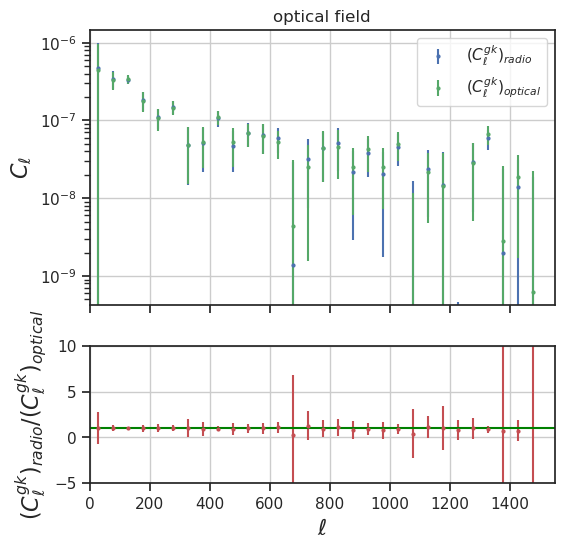

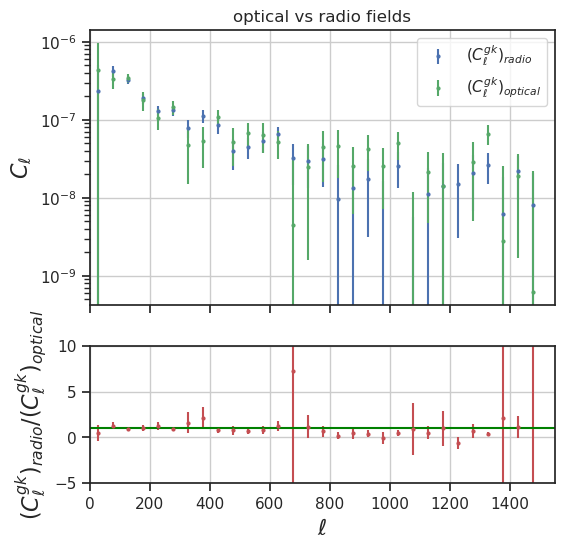

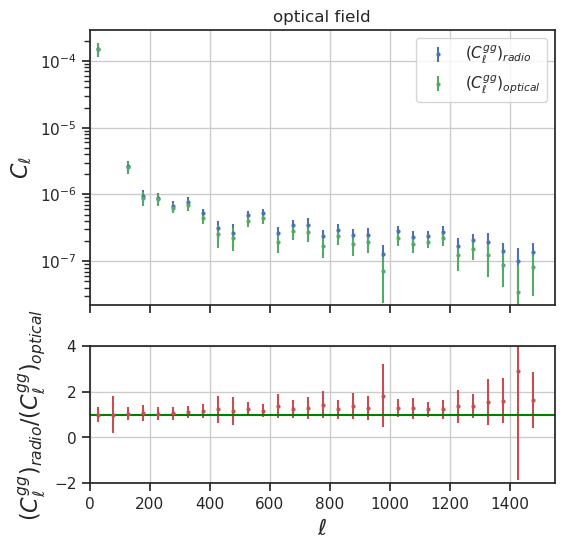

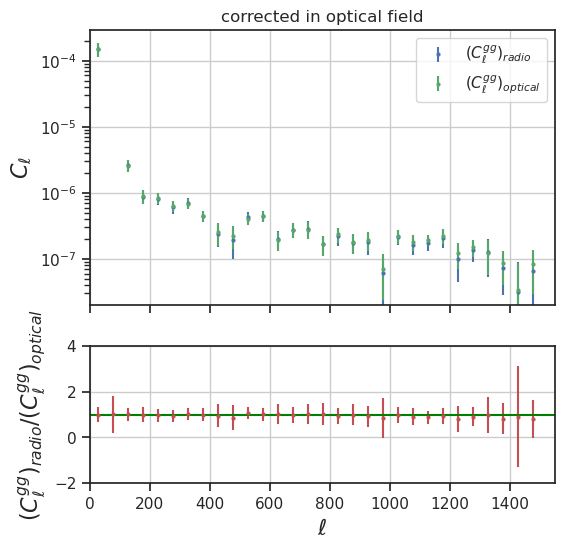

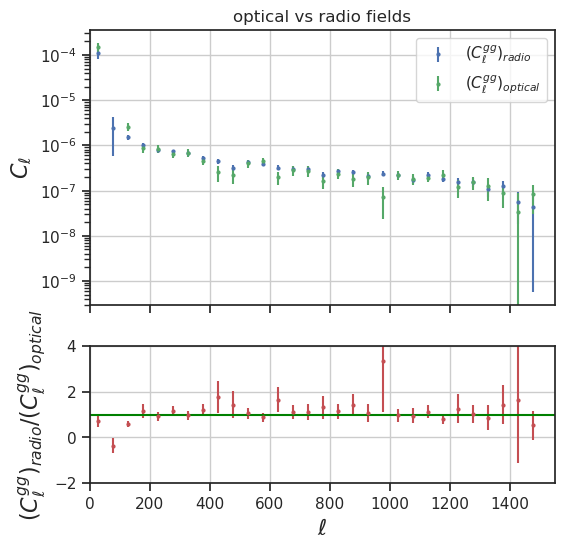

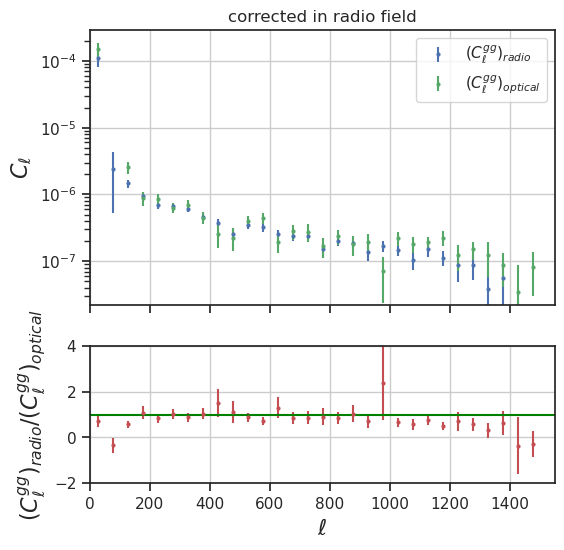

In [9]:
flux_cut = 1.5
signal_to_noise = 7.5
show_multicomponent_shotnoise_report(flux_cut, signal_to_noise)

Base shotnoise: 1.00e-06
Multicomponent shotnoise: 5.26e-08
Multicomponent shotnoise gauss error: 3.03e-08
Multicomponent shotnoise jackknife error: 1.33e-07


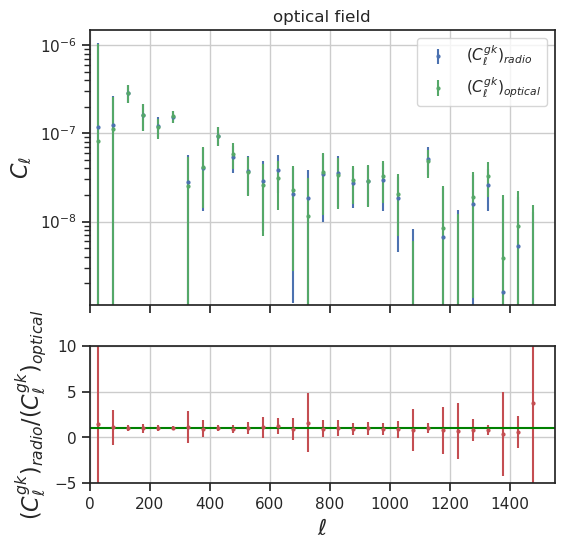

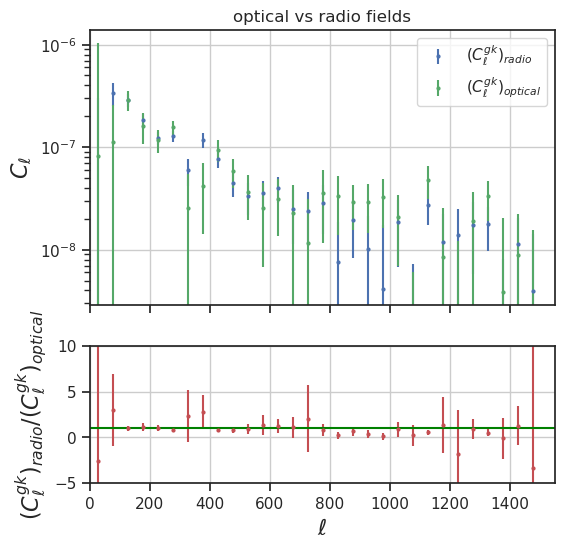

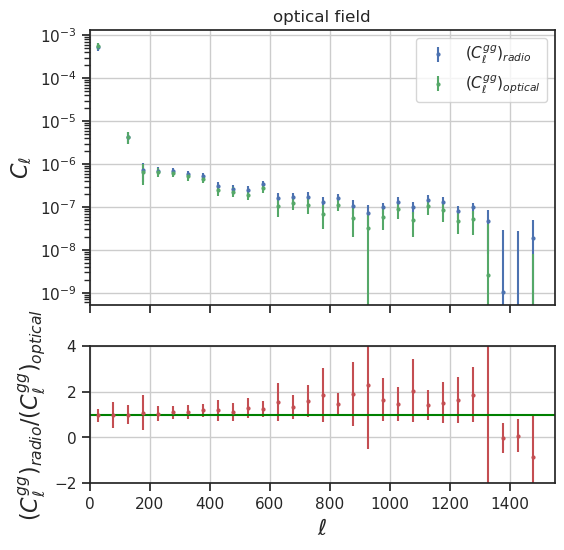

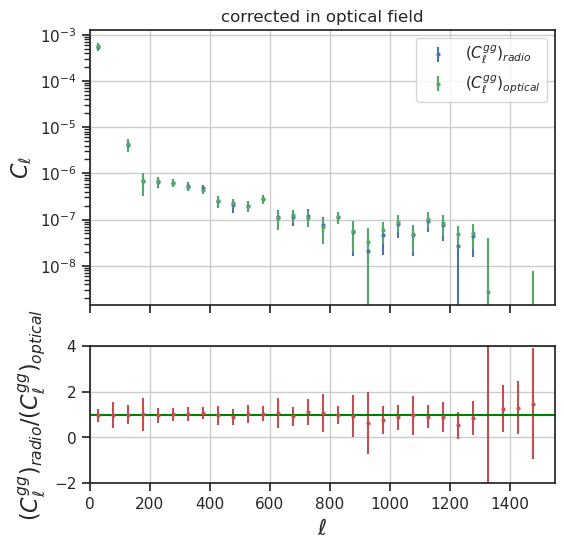

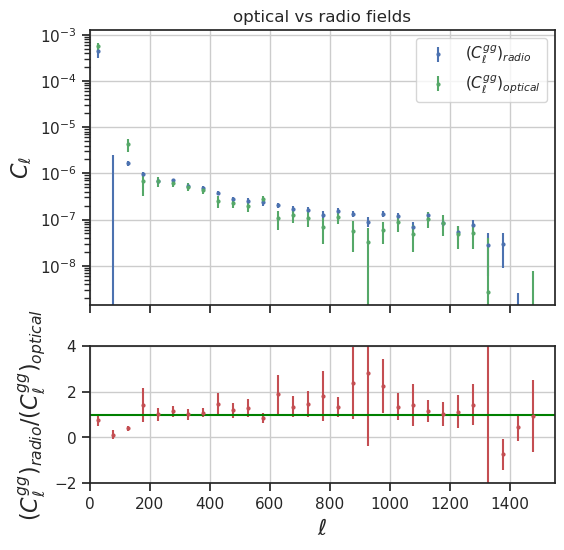

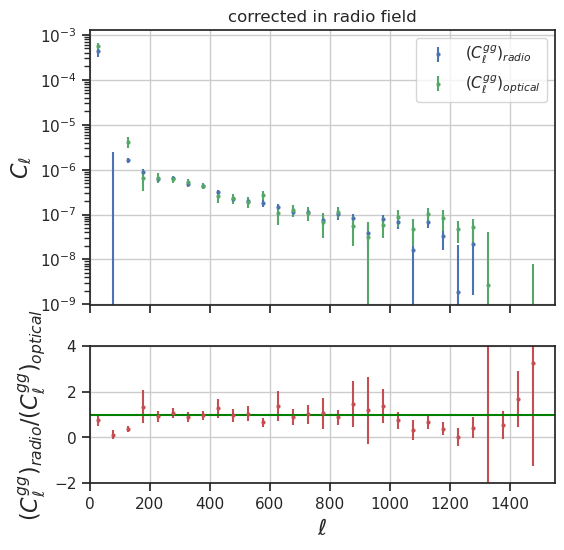

In [10]:
flux_cut = 1
signal_to_noise = 5
show_multicomponent_shotnoise_report(flux_cut, signal_to_noise)

# Jackknife comparison

In [7]:
base_fname = 'LoTSS_DR2/LoTSS_DR2_srl__mask_inner__1.5mJy_snr=7.5_nside=512_gg-gk_bin=50'
corr_13 = read_correlations(base_fname + '_JK13')
corr_50 = read_correlations(base_fname)
corr_200 = read_correlations(base_fname + '_JK200')

In [64]:
diff_1 = (corr_13['error_gg_jackknife'] - corr_50['error_gg_jackknife']) / corr_50['error_gg_jackknife']
diff_2 = (corr_200['error_gg_jackknife'] - corr_50['error_gg_jackknife']) / corr_50['error_gg_jackknife']

np.round(list(zip(diff_1 * 100, diff_2 * 100)), 0)[1:10]

array([[ 29., -29.],
       [-23., -12.],
       [-10.,  13.],
       [-27.,   0.],
       [-37.,  20.],
       [ 15.,  14.],
       [ 23.,   1.],
       [ 12.,   8.],
       [-29.,  -1.]])

In [65]:
diff_1 = (corr_13['error_gk_jackknife'] - corr_50['error_gk_jackknife']) / corr_50['error_gk_jackknife']
diff_2 = (corr_200['error_gk_jackknife'] - corr_50['error_gk_jackknife']) / corr_50['error_gk_jackknife']

np.round(list(zip(diff_1 * 100, diff_2 * 100)), 0)[1:10]

array([[  8.,   9.],
       [-32.,   3.],
       [ -5.,  -5.],
       [ 22.,  16.],
       [ 62.,  16.],
       [ 13.,   2.],
       [-19.,  -8.],
       [-51.,  -8.],
       [  6.,  -5.]])

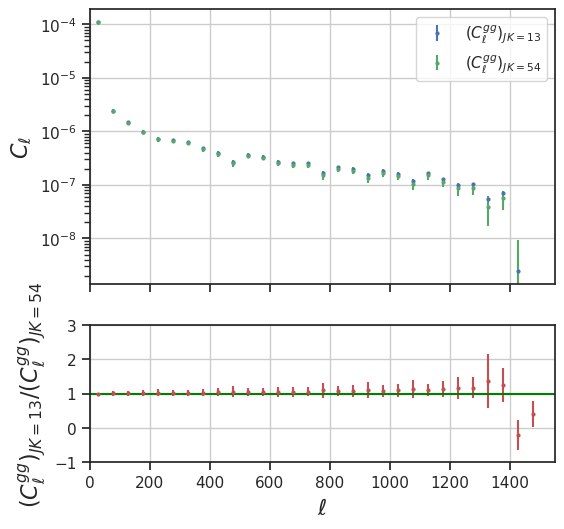

In [38]:
plot_correlation_comparison(corr_13, corr_50, correlation_symbols=['gg', 'gg'], correlation_names=['JK=13', 'JK=54'],
                            x_min=0, x_max=None, y_min=-1, y_max=3, title=None)

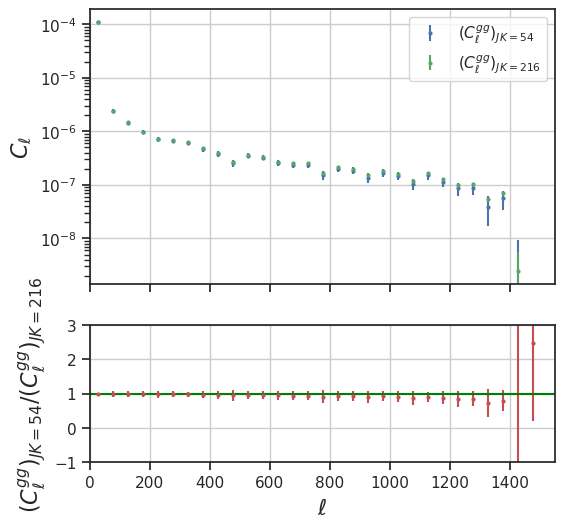

In [39]:
plot_correlation_comparison(corr_50, corr_200, correlation_symbols=['gg', 'gg'], correlation_names=['JK=54', 'JK=216'],
                            x_min=0, x_max=None, y_min=-1, y_max=3, title=None)

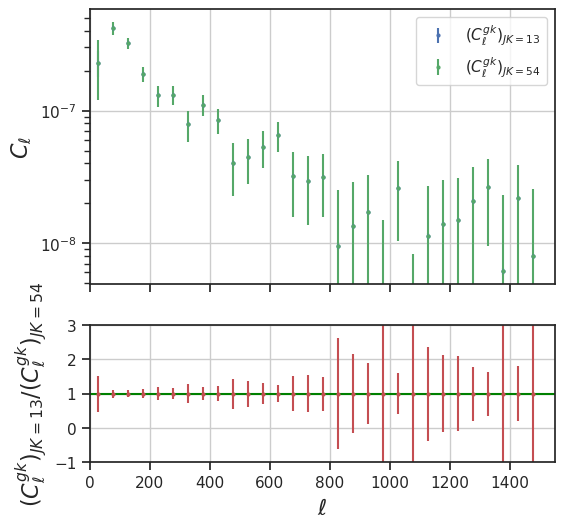

In [40]:
plot_correlation_comparison(corr_13, corr_50, correlation_symbols=['gk', 'gk'], correlation_names=['JK=13', 'JK=54'],
                            x_min=0, x_max=None, y_min=-1, y_max=3, title=None)

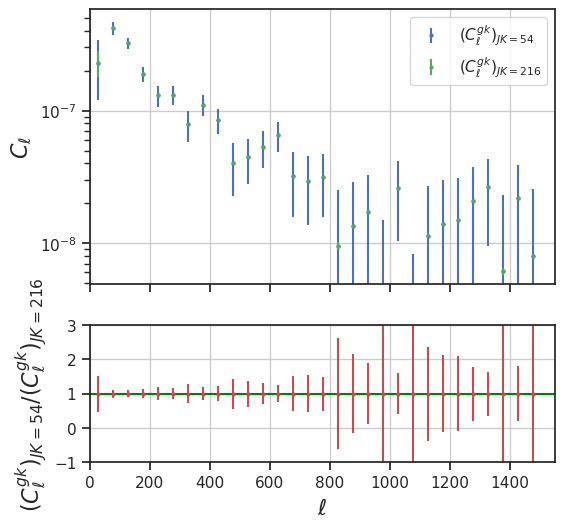

In [41]:
plot_correlation_comparison(corr_50, corr_200, correlation_symbols=['gk', 'gk'], correlation_names=['JK=54', 'JK=216'],
                            x_min=0, x_max=None, y_min=-1, y_max=3, title=None)

# Redshift distribution

## Paper plot

1.5mJy, 7.5SNR: mean 1.17
2.0mJy, 5.0SNR: mean 1.18


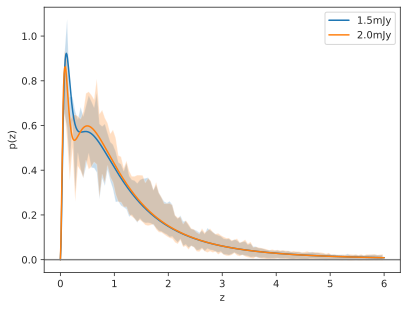

In [7]:
to_plot = [
    (1.5, 7.5, 0.05, 4.93, 0.20),    
    (2.0, 5.0, 0.04, 4.98, 0.17),
]

for i, (flux_cut, snr_cut, z_sfg, a, r) in enumerate(to_plot):
    # Model
    z_arr, n_arr = get_lotss_redshift_distribution(
        model='power_law', z_sfg=z_sfg, a=a, r=r, z_max=6, normalize=True)
    plt.plot(z_arr, n_arr, 'C{}'.format(i), label='{:.1f}mJy'.format(flux_cut))
    
    # Print mean redshift
    mean = np.average(z_arr, weights=n_arr)
    print('{}mJy, {}SNR: mean {:.2f}'.format(flux_cut, snr_cut, mean))
    
    # Deep fields
    pz_file = 'LoTSS/DR2/deep_fields/pz_{}mJy_{}SNR.csv'.format(flux_cut, snr_cut)
    pz_df = pd.read_csv(os.path.join(DATA_PATH, pz_file))
    idx = pz_df['z'] < 6
    z_arr = pz_df['z'][idx]
    n_arr = pz_df['pz_all'][idx]
    err_arr = pz_df['pz_err_all'][idx]
    
    # plt.plot(z_arr, n_arr, 'C{}'.format(i), linestyle='dashed', alpha=0.8)
    plt.fill_between(z_arr, n_arr - err_arr, n_arr + err_arr, alpha=0.25)

plt.axhline(y=0, color='gray', linestyle='-')

# handles, labels = plt.gca().get_legend_handles_labels()
# line = Line2D([0], [0], label='samples', color='C1')
# handles.extend([line])
# plt.legend(handles=handles)

plt.xlabel('z')
plt.ylabel('p(z)')
plt.legend()
# plt.xscale('log')
plt.show()

## Deep fields fitting

In [5]:
import os

from matplotlib import pyplot as plt
from scipy import signal

from env_config import DATA_PATH
from utils import read_fits_to_pandas

flux_cut = 2.0
deepfields_file = 'LoTSS/DR2/pz_deepfields/AllFields_Pz_dat_Fllim1_{}_Final_Trapz_Pz.fits'.format(flux_cut)
pz_deepfields = read_fits_to_pandas(os.path.join(DATA_PATH, deepfields_file))

idx = pz_deepfields['z'] < 6
z_arr = pz_deepfields['z'][idx]
n_arr = pz_deepfields['Nz_weighted_fields_Photoz_only'][idx]
err_arr = pz_deepfields['Nz_fields_err_combafter_Photoz_only'][idx]

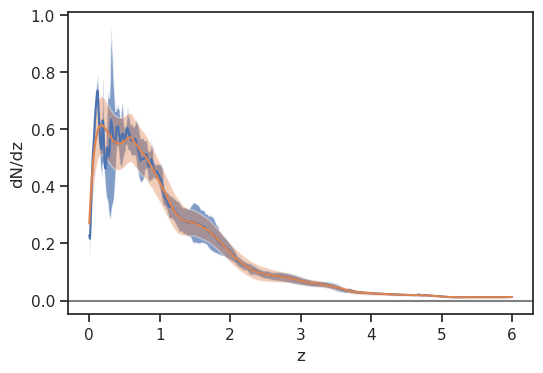

Text(0, 0.5, 'error')

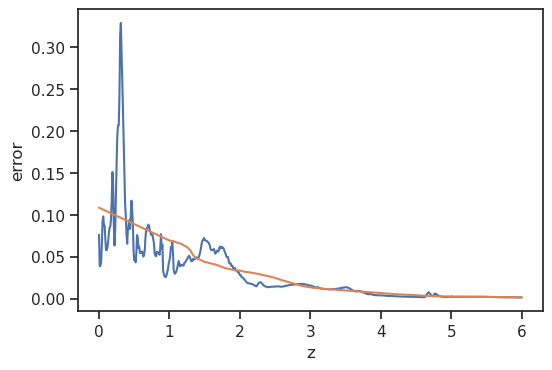

In [10]:
# Original
arr_min = n_arr - err_arr
arr_max = n_arr + err_arr
plt.plot(z_arr, n_arr, label='raw')
plt.fill_between(z_arr, arr_min, arr_max, alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='-')

# Smoothed
n_arr_smth = signal.savgol_filter(n_arr, 101, 5) # window size, polynomial order 
err_arr_smth = signal.savgol_filter(err_arr, 201, 1)

arr_min_smth = n_arr_smth - err_arr_smth
arr_max_smth = n_arr_smth + err_arr_smth

plt.plot(z_arr, n_arr_smth, label='smooth')
plt.fill_between(z_arr, arr_min_smth, arr_max_smth, alpha=0.4)
plt.xlabel('z')
plt.ylabel('dN/dz')
plt.legend()
plt.show()

plt.plot(z_arr, err_arr, label='raw')
plt.plot(z_arr, err_arr_smth, label='smooth')
plt.xlabel('z')
plt.ylabel('error')
plt.legend()
plt.show()

## Double power law

In [59]:
def get_tmp(z_arr, z_sfg=None, a=None, r=None, offset=None, a_2=None, r_2=None, n=1, normalize=True):
    n_arr = n * (z_arr ** 2) / (1 + z_arr) * (np.exp((-z_arr / z_sfg)) + r ** 2 / (1 + z_arr) ** a)
    
    if a_2:
        n_arr_2 = n * ((z_arr - offset) ** 2) / (1 + z_arr - offset) * (r_2 ** 2 / (1 + z_arr - offset) ** a_2)
        n_arr_2[z_arr < offset] = 0
        n_arr += n_arr_2
    
    if normalize:
        area = simps(n_arr, z_arr)
        n_arr /= area
        
    return z_arr, n_arr

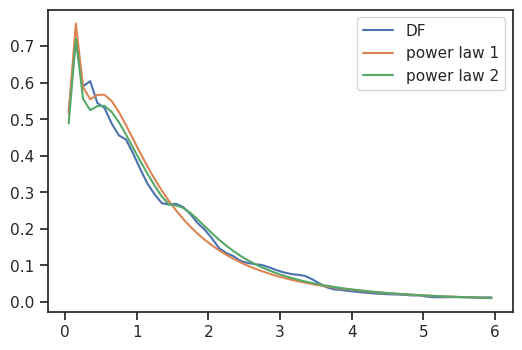

In [77]:
from data_lotss import get_lotss_redshift_distribution

z_arr, deep_fields = get_lotss_redshift_distribution(config=None, model='deep_fields', flux_cut=1.5, z_max=6, normalize=False)
z_arr, power_law_1 = get_tmp(z_arr, z_sfg=0.05, a=4.80, r=0.21, normalize=True)
z_arr, power_law_2 = get_tmp(z_arr, z_sfg=0.05, a=4.80, r=0.21, offset=1.4, a_2=6, r_2=0.08, normalize=True)

plt.plot(z_arr, deep_fields, label='DF')
plt.plot(z_arr, power_law_1, label='power law 1')
plt.plot(z_arr, power_law_2, label='power law 2')

plt.legend()

## Comparison of dp / dz

In [5]:
# Redshift models
data_optical = get_lotss_data(data_release=2, flux_min_cut=None, optical=True, columns=['Total_flux', 'z_best'])
data_skads = get_skads_sim_data()

Original LoTSS DR2 datashape: (1819424, 93)


In [12]:
%reload_ext autoreload

In [13]:
redshift_distributions = get_redshift_distributions(data_optical, data_skads)
redshift_distributions = normalize_dists(redshift_distributions)

FileNotFoundError: [Errno 2] No such file or directory: '/home/snakoneczny/data/LoTSS/DR2/pz_deepfields/Pz_booterrors_wsum_deepfields_15mJy.fits'

In [104]:
# tomographer = pd.read_csv(os.path.join(DATA_PATH, 'LoTSS/tomographer/full_maskstrict_I2mJy_q5.csv'))
# redshift_distributions_bias['tomographer'][2] = {
#     'z': tomographer['z'][:-1],
#     'pz': tomographer['dNdz_b'][:-1],
#     'pz_min': tomographer['dNdz_b'][:-1] - tomographer['dNdz_b_err'][:-1] / 2,
#     'pz_max': tomographer['dNdz_b'][:-1] + tomographer['dNdz_b_err'][:-1] / 2,
# }
redshift_distributions_bias = scale_with_bias(redshift_distributions)

In [105]:
# Bias models
z_arr = redshift_distributions_bias['tomographer fit'][2]['z']
bias_arr = np.ones(len(z_arr))
with open(os.path.join(PROJECT_PATH, 'cosmologies.yml'), 'r') as cosmology_file:
    cosmology_params = yaml.full_load(cosmology_file)['planck']
cosmology = ccl.Cosmology(**cosmology_params)
bias_arr = 1.5 * bias_arr / ccl.growth_factor(cosmology, 1. / (1. + np.array(z_arr)))

bias_models = {
    '1/D(z)': {'z': z_arr, 'b': bias_arr},
}

z_arr_tmp, n_arr_tmp = get_lotss_redshift_distribution(z_sfg=0.15, a=4.8, r=0.91, model='power_law', z_arr=redshift_distributions_bias['tomographer fit'][2]['z'])
bias_models['tomographer fit'] = {'z': redshift_distributions_bias['tomographer fit'][2]['z'], 'b': 1.5 * redshift_distributions_bias['tomographer fit'][2]['pz'] / n_arr_tmp}

/tmp/ipykernel_159629/1765629196.py:14: RuntimeWarning: invalid value encountered in true_divide
  bias_models['tomographer fit'] = {'z': redshift_distributions_bias['tomographer fit'][2]['z'], 'b': 1.5 * redshift_distributions_bias['tomographer fit'][2]['pz'] / n_arr_tmp}


In [106]:
# b g r c m y
styles_z = {
    'deep fields': 'b',
    'deep fields, boot': 'b--',
#     'power law AGN, to deep fields': 'r--',
    # 'power law AGN, DR2': 'r--',
    # 'z tail, DR1': 'g--',
    # 'photo-z, DR2': 'c',
    # 'SKADS': 'g',
    'tomographer fit': 'g',
    'TRECS': 'r',
}

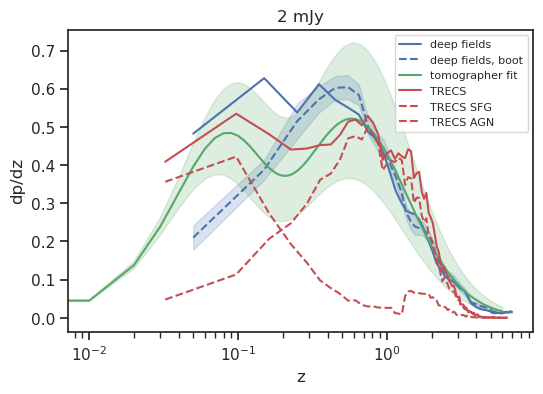

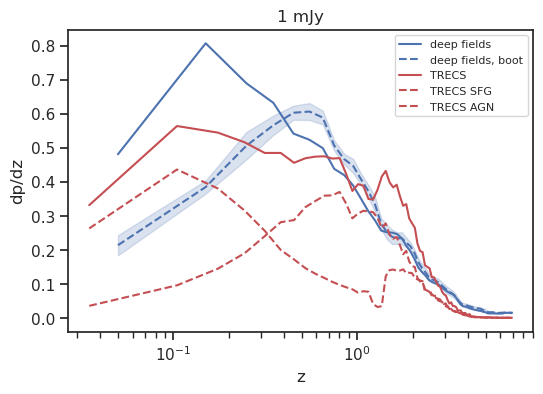

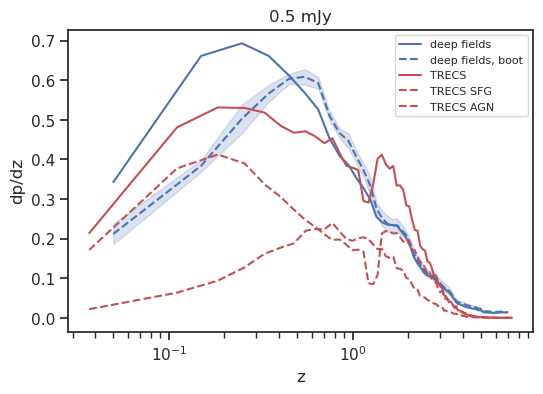

In [107]:
plot_redshift_distributions(redshift_distributions, styles_z, xscale='log', legend_size=8)

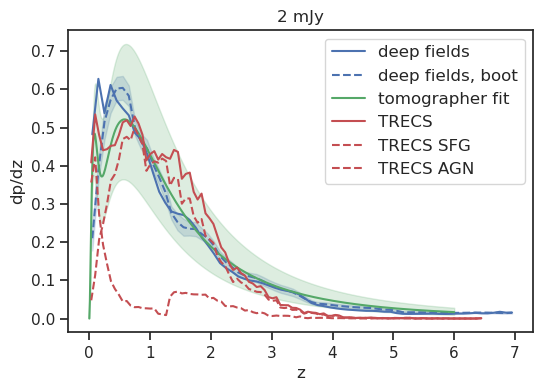

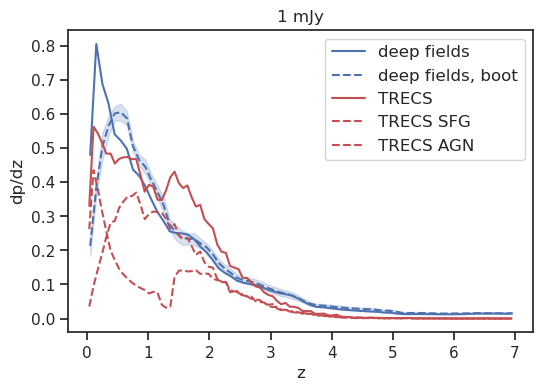

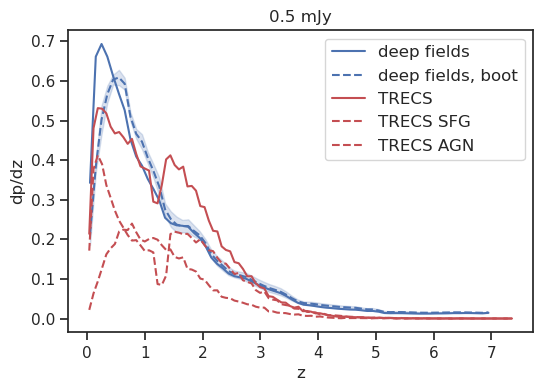

In [108]:
plot_redshift_distributions(redshift_distributions, styles_z, xscale='linear')

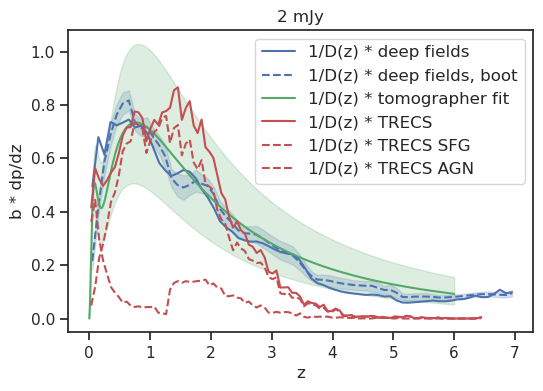

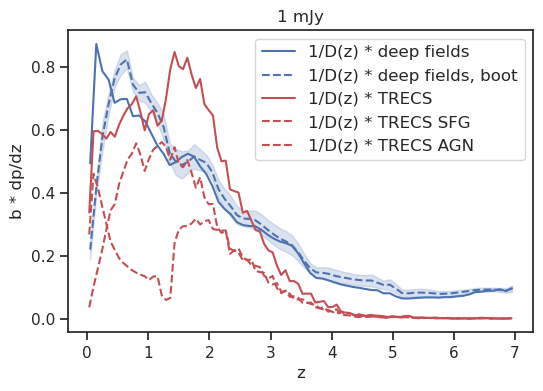

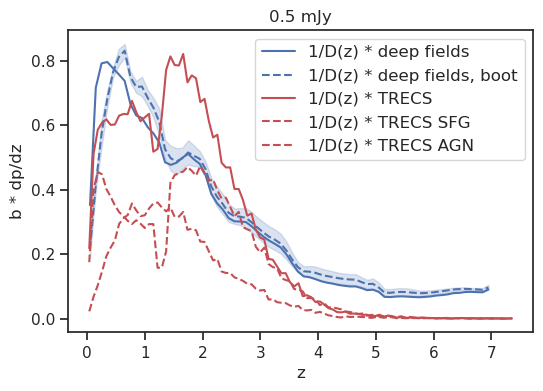

In [109]:
bias_scales = {
    'deep fields': (1, '1/D(z)'),
    'deep fields, boot': (1, '1/D(z)'),
    # 'power law AGN, DR2': (1, '1/D(z)'),
    # 'z tail, DR1': (1, '1/D(z)'),
    'tomographer fit': (1, '1/D(z)'),
    'TRECS': (1, '1/D(z)'),
}
plot_redshift_distributions(redshift_distributions_bias, styles_z, ylabel='b * dp/dz', bias_scales=bias_scales, xscale='linear')

In [110]:
for bias_name, bias_model in bias_models.items():
    y, _ = normalize_dist(bias_model['z'], bias_model['b'])
    plt.plot(bias_model['z'], bias_model['b'], label=bias_name)
    plt.xlim(left=0.05)
    plt.ylim(top=9)
    plt.legend()

NameError: name 'normalize_dist' is not defined

## Tomographer fits

In [19]:
z_sfg_0 = 0.13
a_0 = 4.66
r_0 = 0.94
p_0 = [z_sfg_0, a_0, r_0]

Best fit:  [3.67907719e-02 3.05458553e+00 1.65870250e-01 6.43650935e+02] [1.34397482e-02 1.90600942e-01 8.61068735e-02 6.79273898e+02]
Best fit with bias:  [3.54000092e-02 3.92648868e+00 1.71403269e-01 6.60371418e+02] [1.31260718e-02 1.88156053e-01 9.27054680e-02 7.25733679e+02]


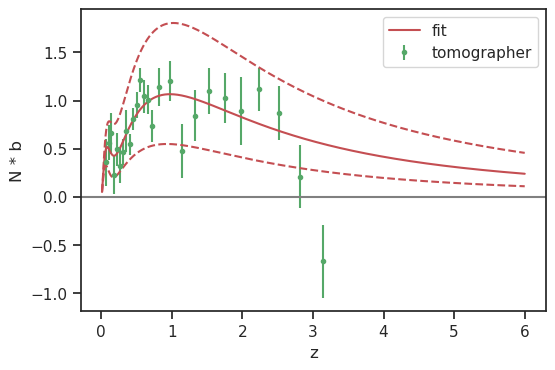

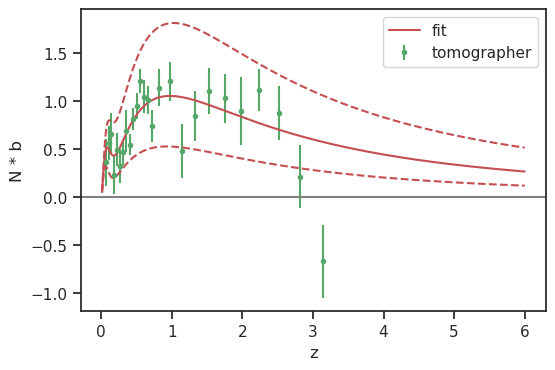

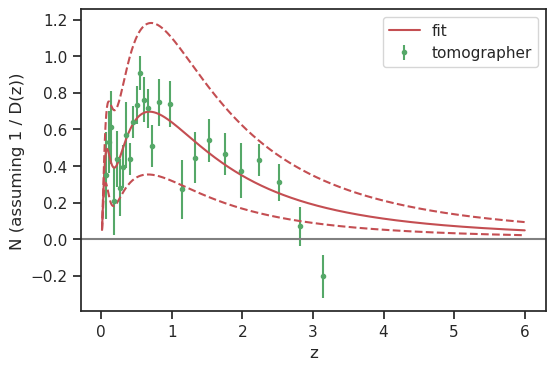

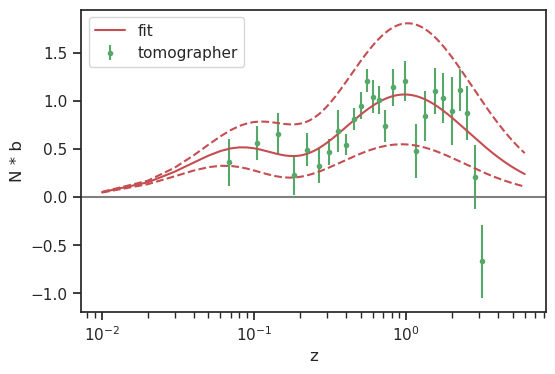

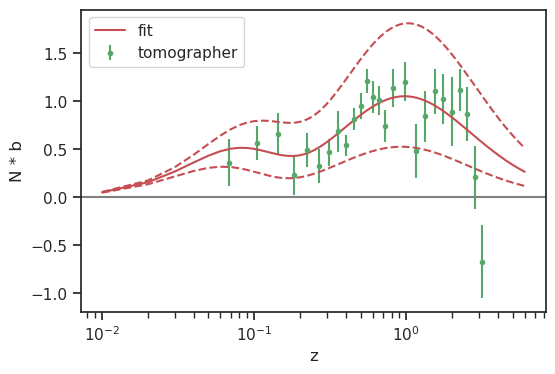

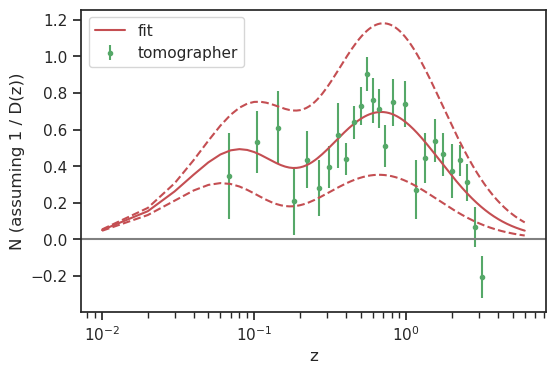

In [ ]:
# Overdensity map, 1.5 mJy, 7.5 SNR, inner mask
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/1.5mJy_7.5SNR_srl_overdensity_inner.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [50], p_0 + [30])

Best fit:  [3.86784639e-02 3.33051715e+00 1.81942793e-01 1.09298136e+05] [1.25595092e-02 2.39659868e-01 8.03138093e-02 9.88234681e+04]
Best fit with bias:  [3.72762721e-02 4.19951123e+00 1.88596699e-01 1.11252080e+05] [1.22415606e-02 2.36312992e-01 8.64939238e-02 1.04508957e+05]


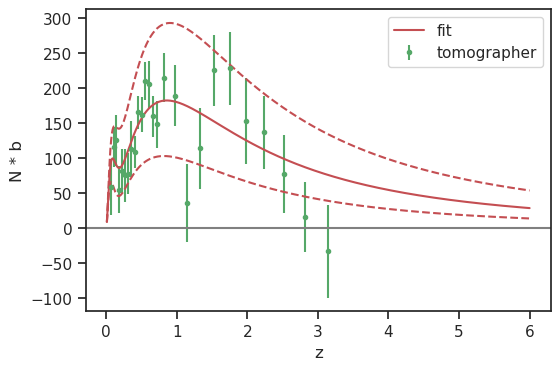

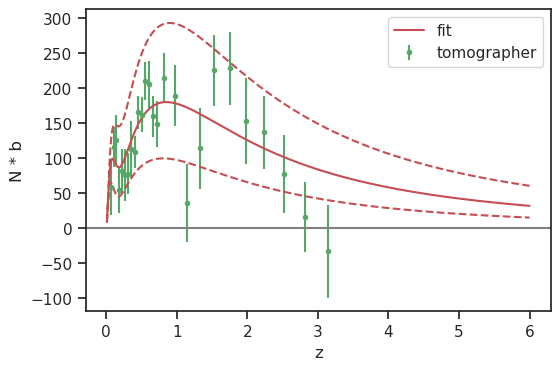

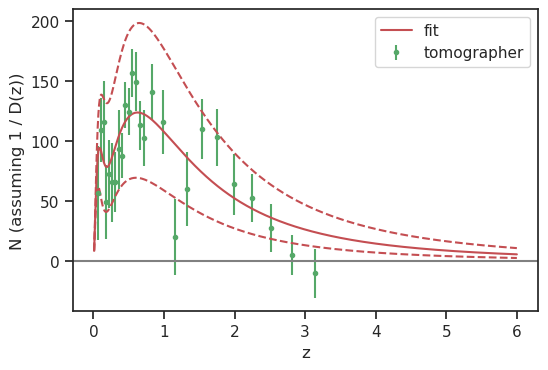

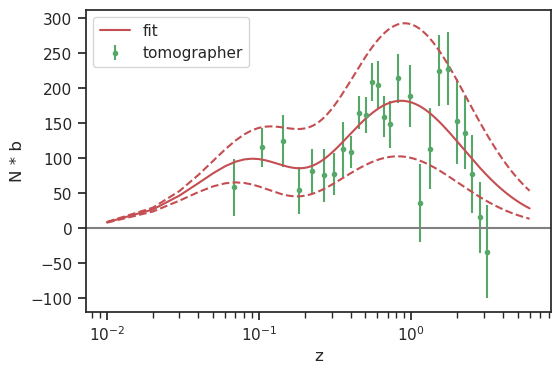

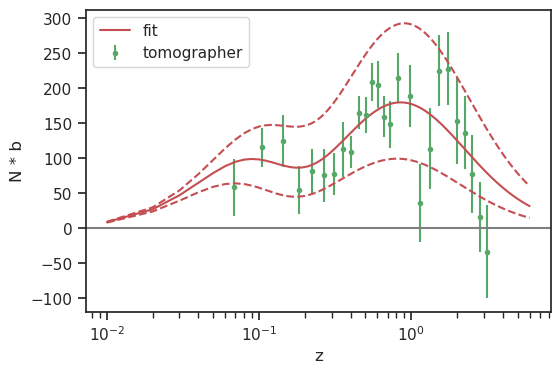

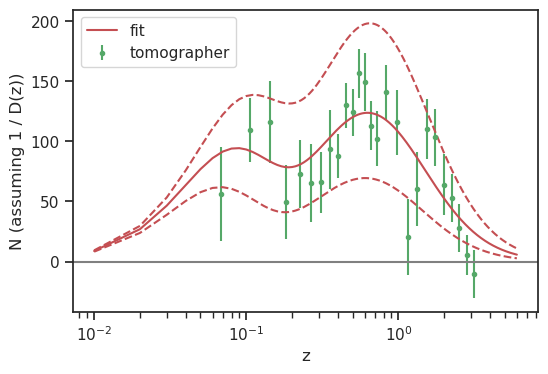

In [20]:
# Catalog, 1.5 mJy, 7.5 SNR, inner mask
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/1.5mJy_7.5SNR_srl_catalog_inner.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [10000], p_0 + [5000])

Best fit:  [3.48539959e-02 3.28642086e+00 1.56322618e-01 8.46433021e+02] [9.58155911e-03 2.09408724e-01 6.09845388e-02 6.73511403e+02]
Best fit with bias:  [3.36345841e-02 4.15214245e+00 1.61290857e-01 8.67622621e+02] [9.35244600e-03 2.06784619e-01 6.51949098e-02 7.14665072e+02]


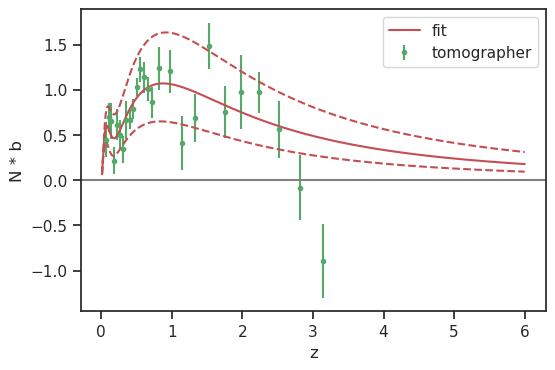

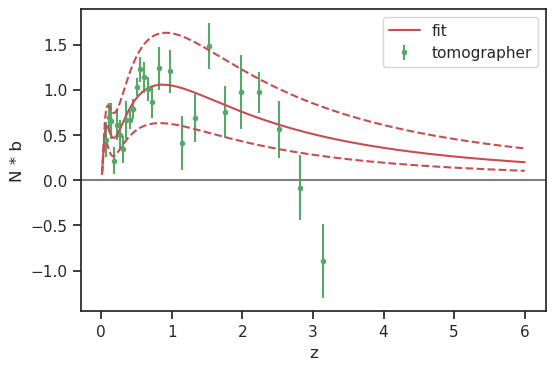

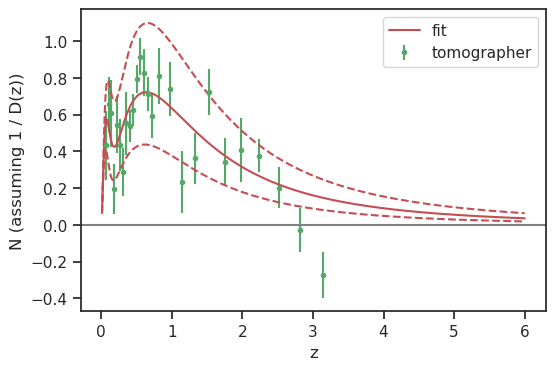

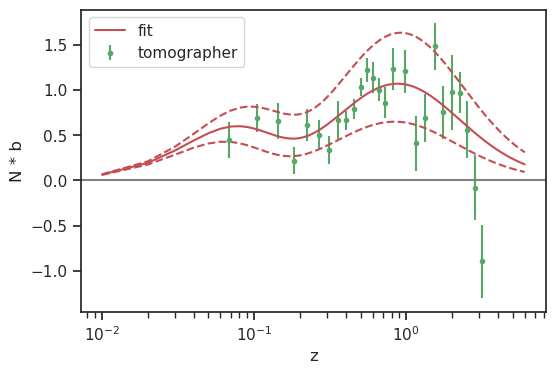

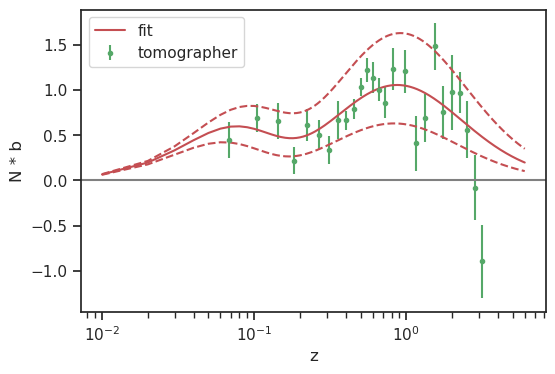

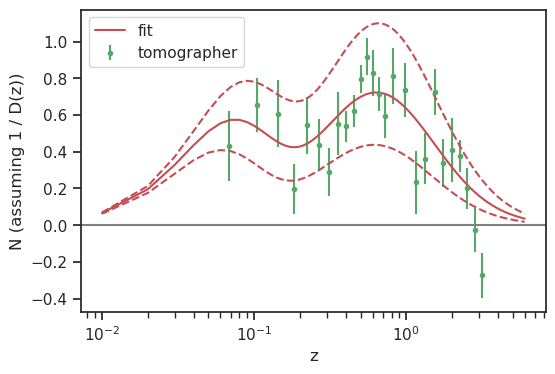

In [8]:
# Overdensity map, 2 mJy, 5 SNR
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/2mJy_5SNR_srl_overdensity_coverage.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [50], p_0 + [30])

Best fit:  [3.80332721e-02 3.48712202e+00 1.78327917e-01 1.05582608e+05] [1.03763390e-02 2.68111693e-01 6.49692199e-02 7.92758594e+04]
Best fit with bias:  [3.67232815e-02 4.35368050e+00 1.84729246e-01 1.07381574e+05] [1.00916653e-02 2.64741691e-01 6.96497138e-02 8.34411543e+04]


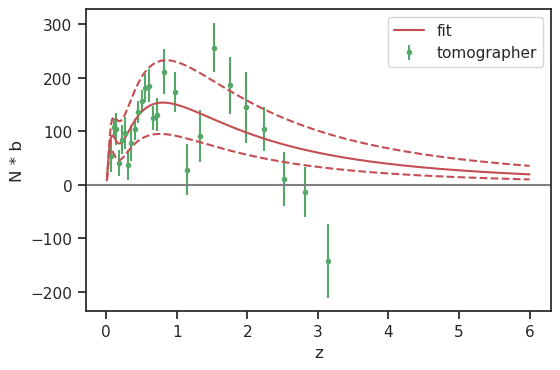

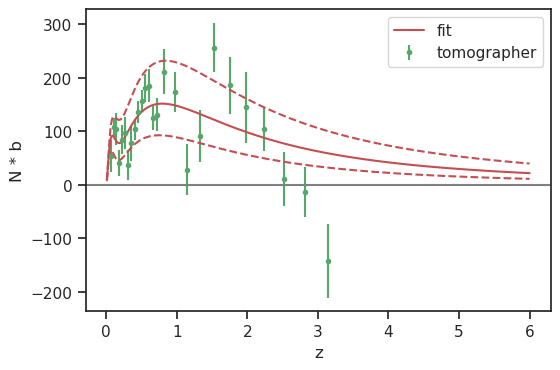

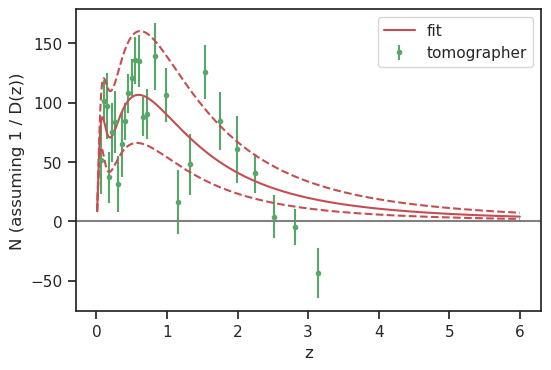

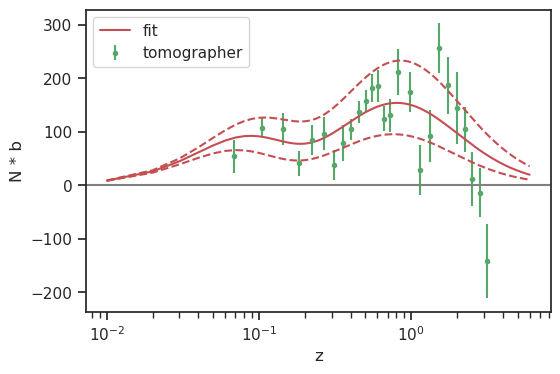

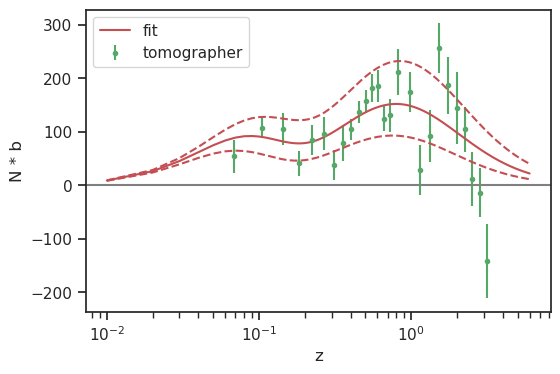

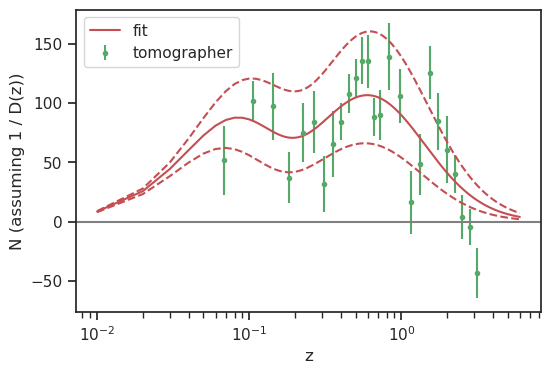

In [9]:
# Catalog, 2 mJy, 5 SNR
filepath = os.path.join(DATA_PATH, 'LoTSS/DR2/tomographer/2mJy_5SNR_srl_catalog_coverage.csv')
make_tomographer_fit(filepath, get_powerlaw_redshift, p_0 + [10000], p_0 + [5000])

## Parametrization

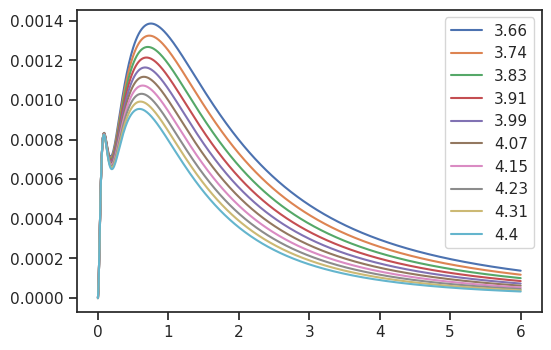

In [18]:
z_sfg = 0.037
a = 4.070
r = 0.183

scale = 0.1
n_lines = 10
for a in np.arange(a * (1 - scale), a * (1 + scale), a * scale / n_lines * 2):
    z_arr, n_arr = get_lotss_redshift_distribution(z_sfg=z_sfg, a=a, r=r, model='power_law', z_max=6, normalize=False)
    plt.plot(z_arr, n_arr, label=np.round(a, 2))
plt.legend()
plt.show()

## Flux cuts on photo-z

In [19]:
data = get_lotss_data(data_release=2, flux_min_cut=None, optical=True)

../data_lotss.py:260: TableReplaceWarning: converted column 'release' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'brickid' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'objid' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'maskbits' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'flag_qual' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'zwarning_sdss' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'plate_sdss' from integer to float
  data = read_fits_to_pandas(data_path)
../data_lotss.py:260: TableReplaceWarning: converted column 'mjd_s

Original LoTSS DR2 datashape: (1819424, 93)


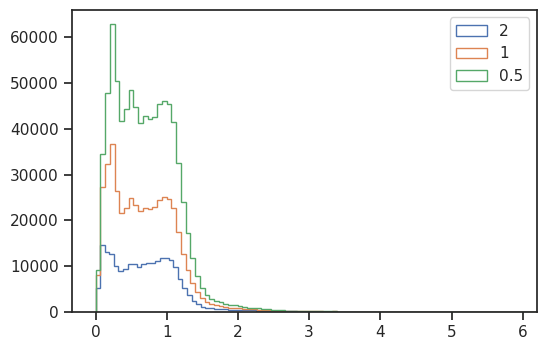

In [25]:
# DR2
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=False)
plt.xlim(right=6.2)
plt.legend()

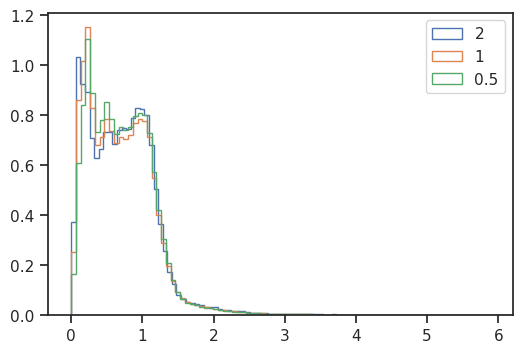

In [26]:
# DR2
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=True)
plt.xlim(right=6.2)
plt.legend()

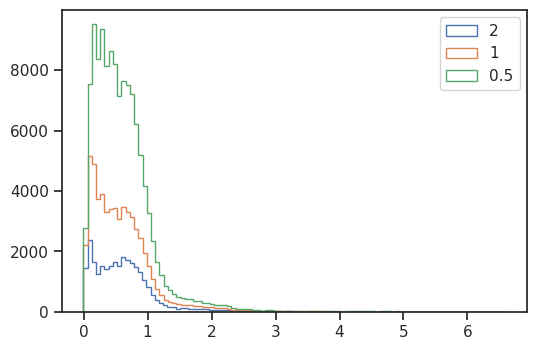

In [11]:
# DR1
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=False)
plt.legend()

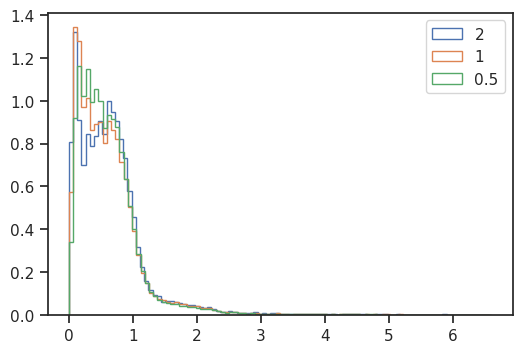

In [29]:
# DR1
for flux_cut in [2, 1, 0.5]:
    data_cut = data.loc[data['Total_flux'] > flux_cut]
    plt.hist(data_cut['z_best'], bins=100, label=flux_cut, histtype='step', density=True)
plt.legend()

# Maps

## For paper

29/05/2023 19:10:58 INFO: NSIDE = 256
29/05/2023 19:10:58 INFO: ORDERING = RING in fits file
29/05/2023 19:10:58 INFO: INDXSCHM = IMPLICIT
29/05/2023 19:10:58 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
29/05/2023 19:10:58 INFO: -> fwhm is 60.000000 arcmin
29/05/2023 19:10:58 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
29/05/2023 19:10:58 INFO: -> fwhm is 0.000000 arcmin
29/05/2023 19:10:59 INFO: 0.0 180.0 -180.0 180.0
29/05/2023 19:10:59 INFO: The interval between parallels is 30 deg -0.00'.
29/05/2023 19:10:59 INFO: The interval between meridians is 30 deg -0.00'.


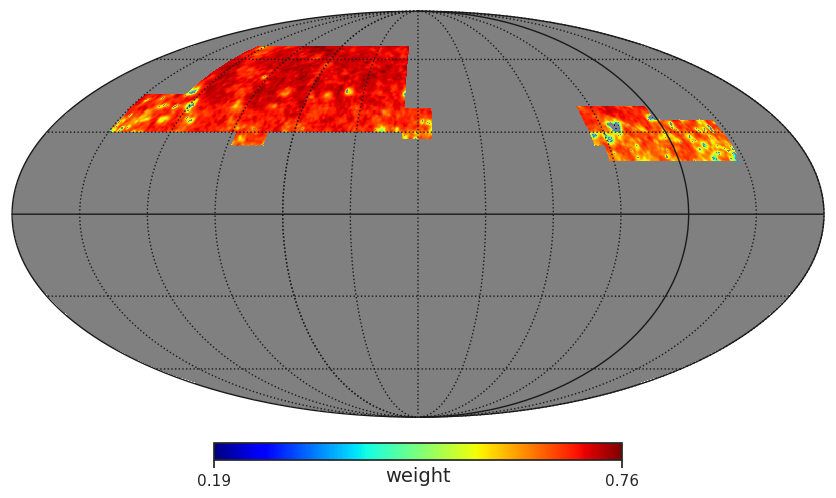

In [14]:
from data_lotss import get_lotss_dr2_mask
from data_lotss import read_lotss_noise_weight_map
from utils import get_masked_map

mask = experiment.masks['g'].filled(0)
weights = read_lotss_noise_weight_map(nside=512, data_release=2, flux_min_cut=1.5, signal_to_noise=7.5)

weights = hp.sphtfunc.smoothing(weights, fwhm=math.radians(1.0))

weights = get_masked_map(weights, mask)

hp.mollview(weights, cmap='jet', rot=120, unit='weight', format='%.2f', title=None)
hp.graticule()

29/05/2023 19:12:35 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
29/05/2023 19:12:35 INFO: -> fwhm is 60.000000 arcmin
29/05/2023 19:12:35 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
29/05/2023 19:12:35 INFO: -> fwhm is 0.000000 arcmin
29/05/2023 19:12:36 INFO: 0.0 180.0 -180.0 180.0
29/05/2023 19:12:36 INFO: The interval between parallels is 30 deg -0.00'.
29/05/2023 19:12:36 INFO: The interval between meridians is 30 deg -0.00'.
29/05/2023 19:12:36 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
29/05/2023 19:12:36 INFO: -> fwhm is 60.000000 arcmin
29/05/2023 19:12:36 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
29/05/2023 19:12:36 INFO: -> fwhm is 0.000000 arcmin
29/05/2023 19:12:36 INFO: 0.0 180.0 -180.0 180.0
29/05/2023 19:12:36 INFO: The interval between parallels is 30 deg -0.00'.
29/05/2023 19:12:36 INFO: The interval between meridians is 30 deg -0.00'.
29/05/2023 19:12:36 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
29/05/2023 19:12:36 INFO: -> fwhm is 60.000000 arc

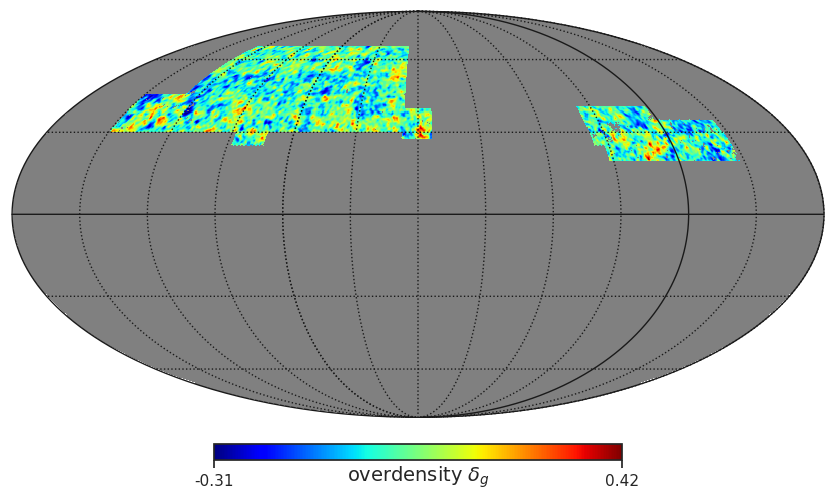

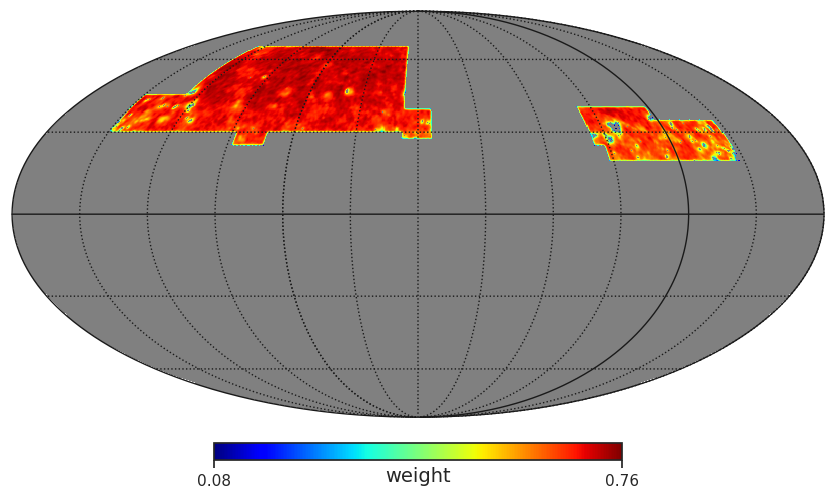

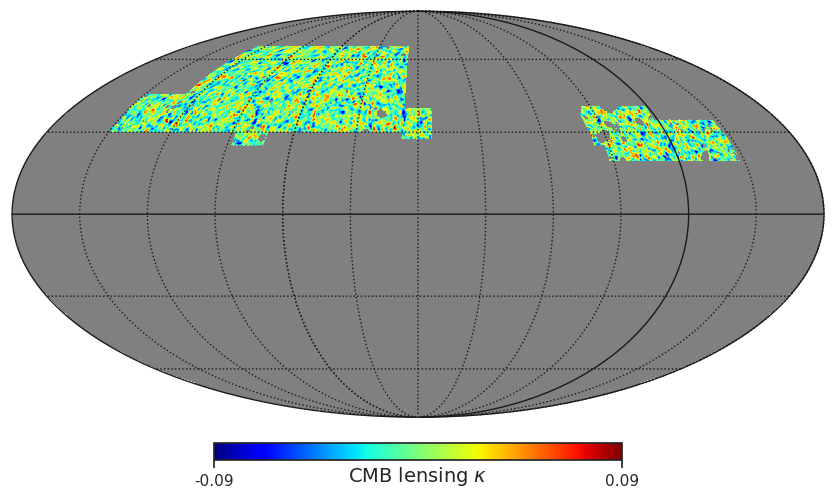

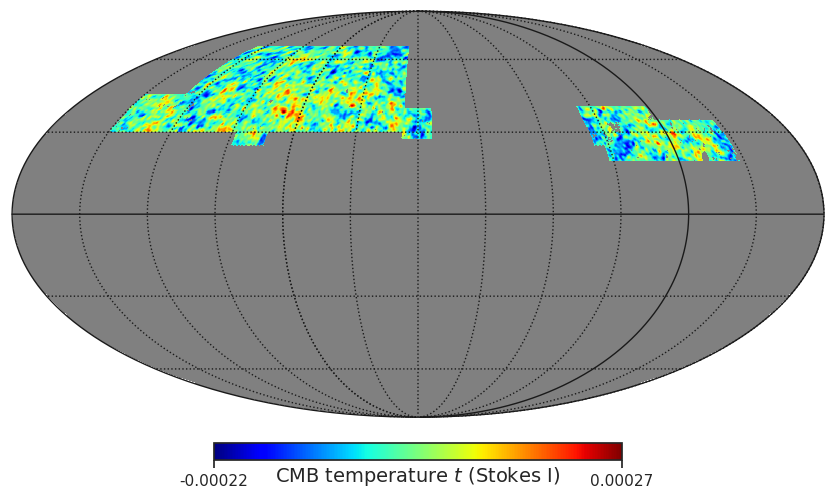

In [15]:
%matplotlib inline

# overdensity
my_mollview(experiment.processed_maps['g'], rot=120, fwhm=1.0, unit='overdensity $\delta_g$', format='%.2f', cmap='jet')

# mask with weights
my_mollview(experiment.masks['g'], rot=120, fwhm=1.0, unit='weight', format='%.2f', cmap='jet')

# lensing
my_mollview(experiment.base_maps['k'], rot=120, fwhm=1.0, additional_mask=experiment.masks['g'], format='%.2f', unit='CMB lensing $\kappa$', cmap='jet')

# temperature
my_mollview(experiment.base_maps['t'], rot=120, fwhm=1.0, additional_mask=experiment.masks['g'], format='%.5f', unit='CMB temperature $t$ (Stokes I)', cmap='jet')

20/09/2022 15:54:12 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
20/09/2022 15:54:12 INFO: -> fwhm is 60.000000 arcmin
20/09/2022 15:54:12 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
20/09/2022 15:54:12 INFO: -> fwhm is 0.000000 arcmin
20/09/2022 15:54:12 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
20/09/2022 15:54:12 INFO: -> fwhm is 60.000000 arcmin
20/09/2022 15:54:12 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
20/09/2022 15:54:12 INFO: -> fwhm is 0.000000 arcmin
20/09/2022 15:54:13 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
20/09/2022 15:54:13 INFO: -> fwhm is 60.000000 arcmin
20/09/2022 15:54:13 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
20/09/2022 15:54:13 INFO: -> fwhm is 0.000000 arcmin
20/09/2022 15:54:13 INFO: Sigma is 25.479654 arcmin (0.007412 rad) 
20/09/2022 15:54:13 INFO: -> fwhm is 60.000000 arcmin
20/09/2022 15:54:13 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
20/09/2022 15:54:13 INFO: -> fwhm is 0.000000 arcmin


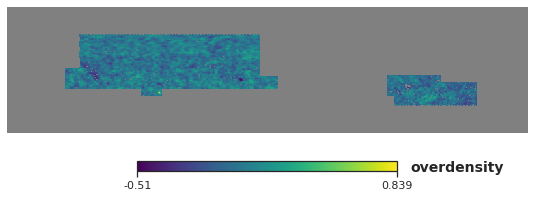

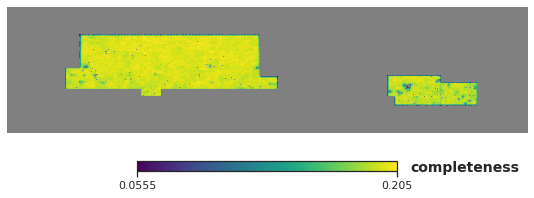

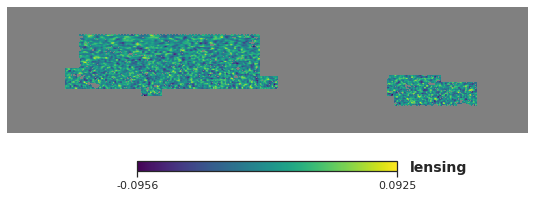

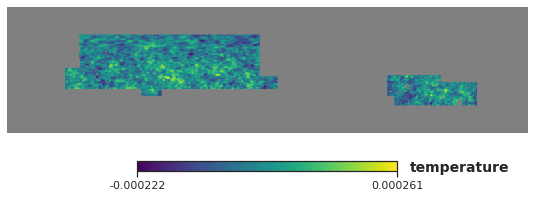

In [62]:
fwhm = 1.0  # degrees

rot = (120, 0, 0)
latra = [0, 87]

# overdensity
g_tmp = hp.sphtfunc.smoothing(experiment.processed_maps['g'], fwhm=math.radians(fwhm))
hp.visufunc.cartview(map=g_tmp, unit='overdensity', rot=rot, latra=latra, title='', cmap='viridis')

# mask with weights
m_tmp = hp.sphtfunc.smoothing(experiment.masks['g'], fwhm=math.radians(fwhm))
hp.visufunc.cartview(map=m_tmp, unit='completeness', rot=rot, latra=latra, title='', cmap='viridis')

# lensing
k_tmp = copy.copy(experiment.base_maps['k'])
k_tmp.mask = np.logical_or(k_tmp.mask, np.logical_not(experiment.masks['g']))
k_tmp = hp.sphtfunc.smoothing(k_tmp, fwhm=math.radians(fwhm))
hp.visufunc.cartview(map=k_tmp, unit='lensing', rot=rot, latra=latra, title='', cmap='viridis')

# temperature
t_tmp = copy.copy(experiment.base_maps['t'])
t_tmp.mask = np.logical_or(t_tmp.mask, np.logical_not(experiment.masks['g']))
t_tmp = hp.sphtfunc.smoothing(t_tmp, fwhm=math.radians(fwhm))
hp.visufunc.cartview(map=t_tmp, unit='temperature', rot=rot, latra=latra, title='', cmap='viridis')

## Jackknife

In [22]:
masks = get_jackknife_masks(experiment.masks['g'], LOTSS_JACKKNIFE_REGIONS, nside=512)

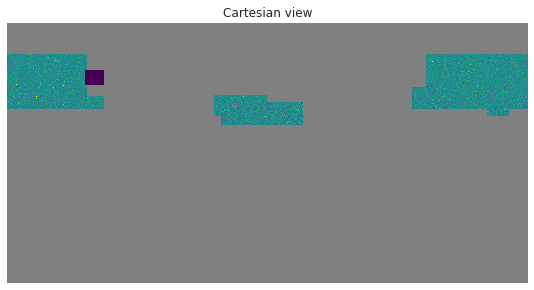

In [24]:
%matplotlib inline
hp.visufunc.cartview(map=masks[2], xsize=1000, badcolor='gray', bgcolor='white', cbar=False, norm=None, cmap='viridis')

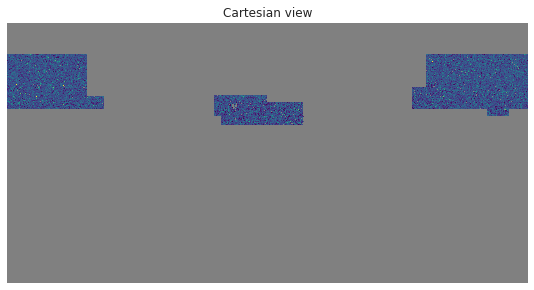

In [28]:
%matplotlib inline
hp.visufunc.cartview(map=experiment.masks['g'], xsize=1000, badcolor='gray', bgcolor='white', cbar=False, norm=None,cmap='viridis')

In [17]:
regions = [
    {'lon': (100, -113 + 360, 11), 'lat': (25, 68, 4)},
    {'lon': (-37, 25, 5), 'lat': (19, 40, 2)},
]

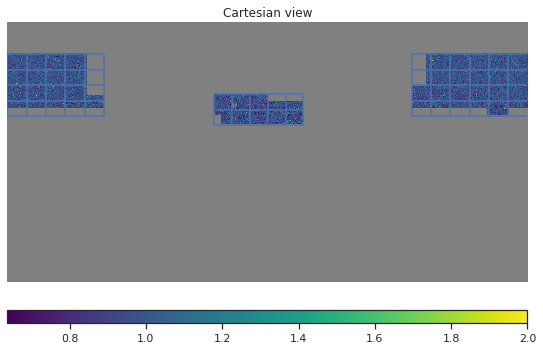

In [29]:
plot_jackknife_regions(experiment, regions)

## Subregions

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globa

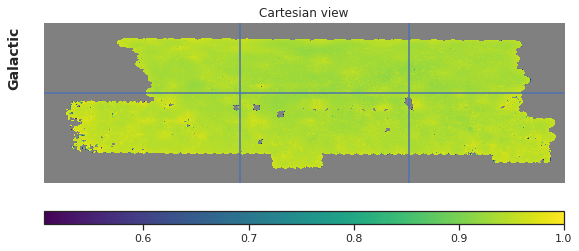

In [7]:
%matplotlib inline
hp.visufunc.cartview(map=experiment.masks['g'], xsize=1000, lonra=[105, -70], latra=[18, 75], badcolor='gray', bgcolor='white', cbar=False, coord='G', norm=None, cmap='viridis')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
fig.colorbar(image, orientation='horizontal', aspect=40, pad=0.08, ax=ax)

lat_arr = [50]
lon_arr = [-160, -220]
for lat in lat_arr:
    lon_range = np.arange(-360, 0, 1)
    plt.plot(lon_range, [lat] * len(lon_range), 'b')
for lon in lon_arr:
    lat_range = np.arange(-90, 90, 1)
    plt.plot([lon] * len(lat_range), lat_range, 'b')

plt.show()

## Interactive

28/03/2022 13:47:56 WARNING: 0.0 180.0 -180.0 180.0
28/03/2022 13:47:56 INFO: The interval between parallels is 30 deg -0.00'.
28/03/2022 13:47:56 INFO: The interval between meridians is 30 deg -0.00'.
28/03/2022 13:47:56 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
28/03/2022 13:47:56 INFO: The interval between parallels is 1 deg 0.00'.
28/03/2022 13:47:56 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
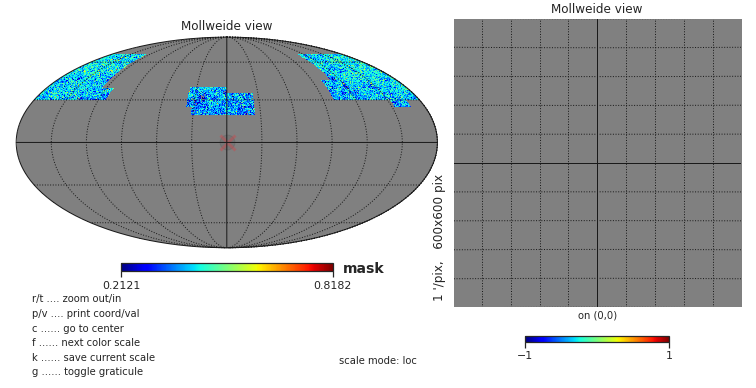

In [9]:
%matplotlib widget
my_mollview(experiment.masks['g'], unit='mask', fwhm=0, zoom=True)

16/03/2022 13:40:23 INFO: Sigma is 5.095931 arcmin (0.001482 rad) 
16/03/2022 13:40:23 INFO: -> fwhm is 12.000000 arcmin
16/03/2022 13:40:23 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
16/03/2022 13:40:23 INFO: -> fwhm is 0.000000 arcmin
16/03/2022 13:40:23 WARNING: 0.0 180.0 -180.0 180.0
16/03/2022 13:40:23 INFO: The interval between parallels is 30 deg -0.00'.
16/03/2022 13:40:23 INFO: The interval between meridians is 30 deg -0.00'.
16/03/2022 13:40:23 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
16/03/2022 13:40:23 INFO: The interval between parallels is 1 deg 0.00'.
16/03/2022 13:40:23 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
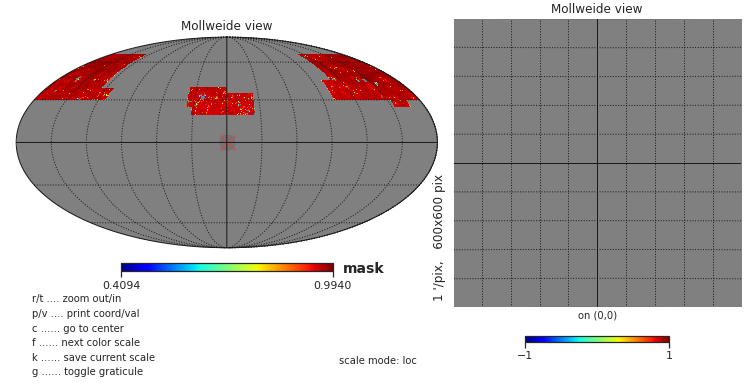

In [73]:
%matplotlib widget
my_mollview(experiment.masks['g'], unit='mask', fwhm=0.2, zoom=True)

09/02/2022 15:47:02 INFO: Sigma is 12.739827 arcmin (0.003706 rad) 
09/02/2022 15:47:02 INFO: -> fwhm is 30.000000 arcmin
09/02/2022 15:47:02 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
09/02/2022 15:47:02 INFO: -> fwhm is 0.000000 arcmin
09/02/2022 15:47:02 WARNING: 0.0 180.0 -180.0 180.0
09/02/2022 15:47:02 INFO: The interval between parallels is 30 deg -0.00'.
09/02/2022 15:47:02 INFO: The interval between meridians is 30 deg -0.00'.
09/02/2022 15:47:02 WARNING: 82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
09/02/2022 15:47:02 INFO: The interval between parallels is 1 deg 0.00'.
09/02/2022 15:47:02 INFO: The interval between meridians is 1 deg 0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
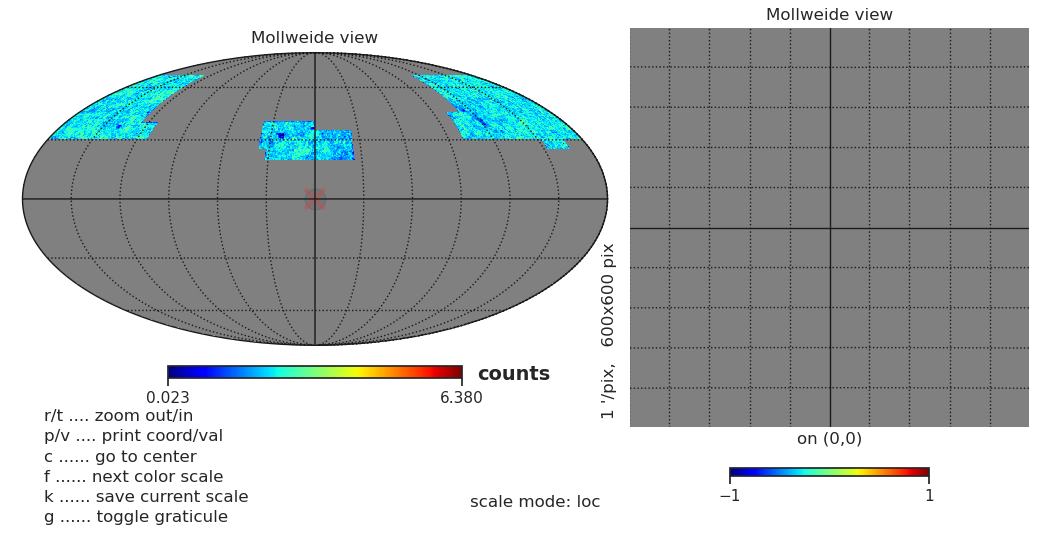

In [28]:
%matplotlib widget
my_mollview(experiment.base_maps['g'], unit='counts', fwhm=0.5, zoom=True)

09/02/2022 15:45:45 INFO: Sigma is 20.383723 arcmin (0.005929 rad) 
09/02/2022 15:45:45 INFO: -> fwhm is 48.000000 arcmin
09/02/2022 15:45:45 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
09/02/2022 15:45:45 INFO: -> fwhm is 0.000000 arcmin
09/02/2022 15:45:45 WARNING: 0.0 180.0 -180.0 180.0
09/02/2022 15:45:45 INFO: The interval between parallels is 30 deg -0.00'.
09/02/2022 15:45:46 INFO: The interval between meridians is 30 deg -0.00'.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
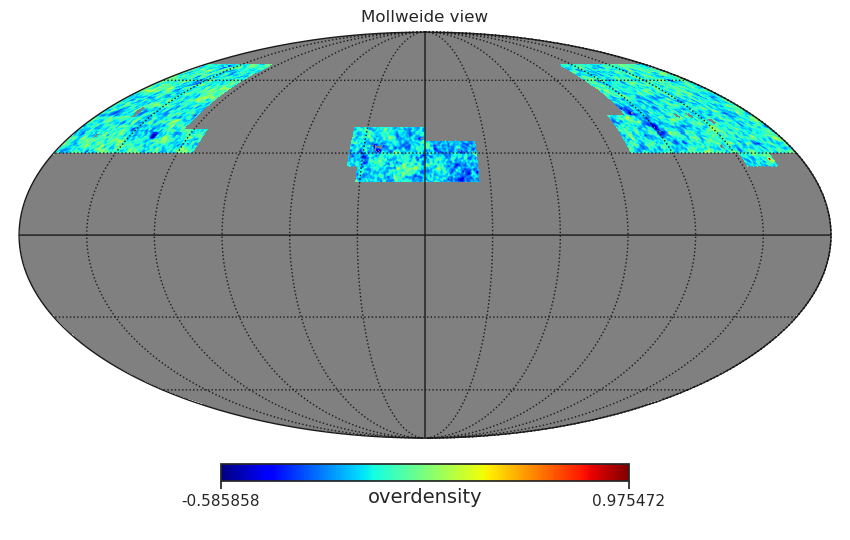

In [20]:
%matplotlib widget
my_mollview(experiment.processed_maps['g'], unit='overdensity', fwhm=0.8)

## Non interactive

07/06/2022 15:08:35 INFO: Sigma is 30.575585 arcmin (0.008894 rad) 
07/06/2022 15:08:35 INFO: -> fwhm is 72.000000 arcmin
07/06/2022 15:08:35 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
07/06/2022 15:08:35 INFO: -> fwhm is 0.000000 arcmin
07/06/2022 15:08:36 WARNING: 0.0 180.0 -180.0 180.0
07/06/2022 15:08:36 INFO: The interval between parallels is 30 deg -0.00'.
07/06/2022 15:08:36 INFO: The interval between meridians is 30 deg -0.00'.


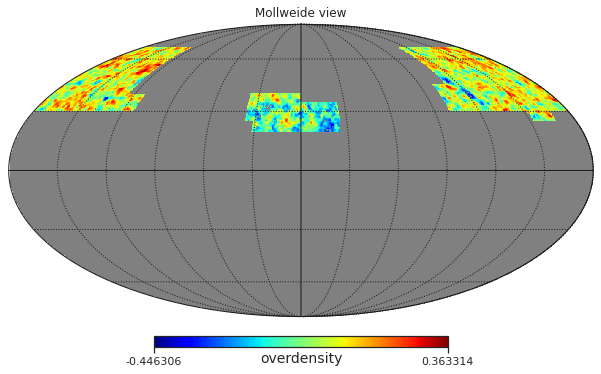

In [18]:
%matplotlib inline
my_mollview(experiment.processed_maps['g'], unit='overdensity', fwhm=1.2, zoom=False)

07/06/2022 15:00:06 INFO: Sigma is 30.575585 arcmin (0.008894 rad) 
07/06/2022 15:00:06 INFO: -> fwhm is 72.000000 arcmin
07/06/2022 15:00:06 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
07/06/2022 15:00:06 INFO: -> fwhm is 0.000000 arcmin
07/06/2022 15:00:06 WARNING: 0.0 180.0 -180.0 180.0
07/06/2022 15:00:06 INFO: The interval between parallels is 30 deg -0.00'.
07/06/2022 15:00:06 INFO: The interval between meridians is 30 deg -0.00'.


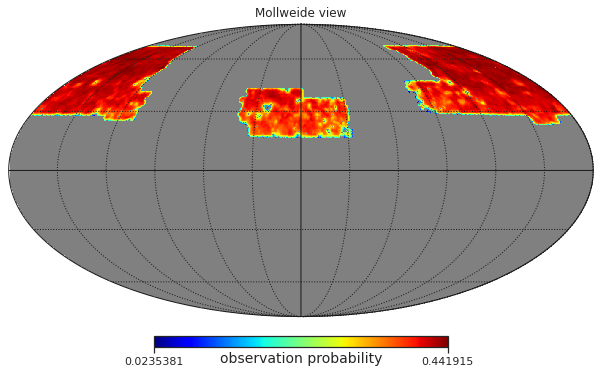

In [17]:
%matplotlib inline
my_mollview(experiment.masks['g'], unit='observation probability', fwhm=1.2, zoom=False)

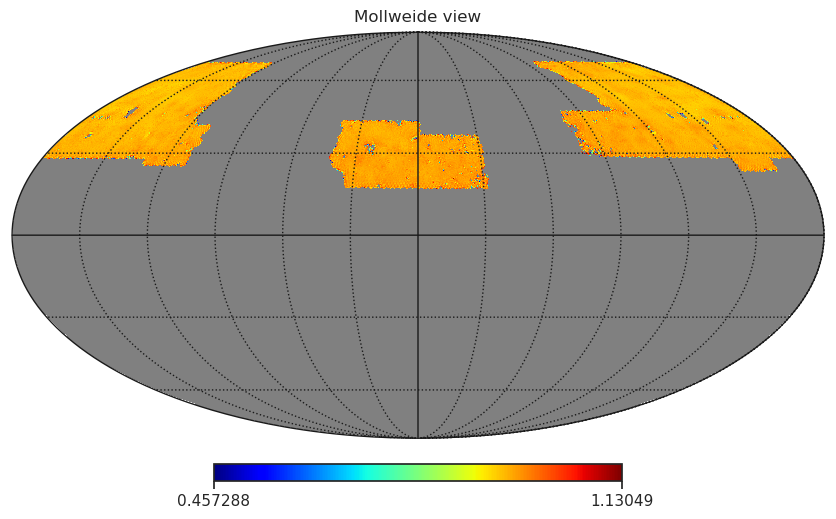

In [18]:
my_mollview(experiment.masks['g'], unit='', fwhm=0.002)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 40.767446 arcmin (0.011859 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 96.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


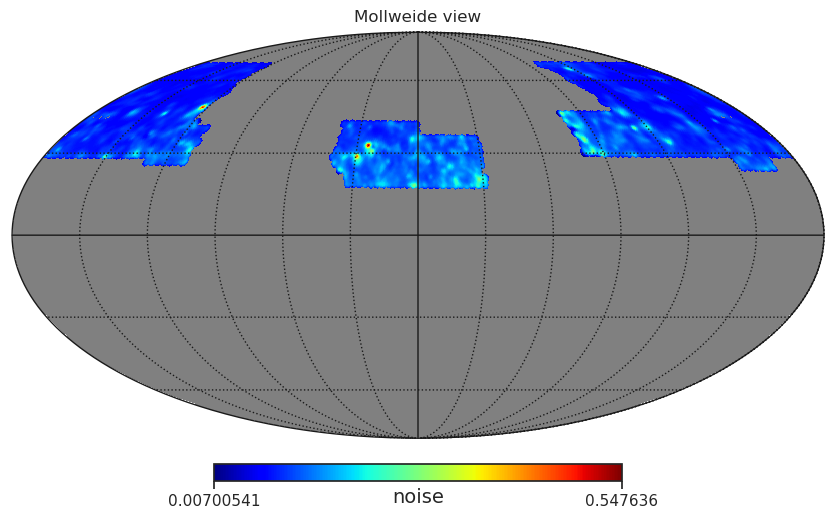

In [13]:
my_mollview(experiment.noise_maps['g'], unit='noise', fwhm=1.6)

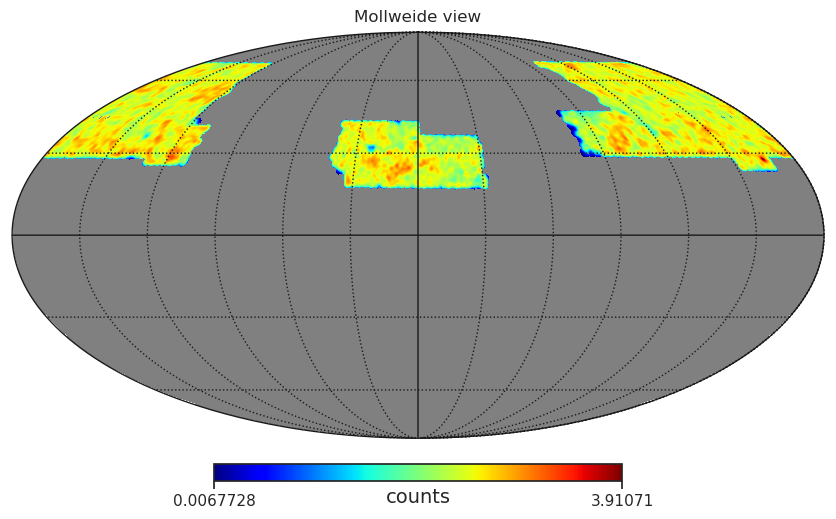

In [14]:
my_mollview(experiment.base_maps['g'], unit='counts', fwhm=1.4)

In [9]:
my_mollview(experiment.processed_maps['t'], unit='mK', fwhm=1.2)

KeyError: 't'

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 15.287792 arcmin (0.004447 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 36.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


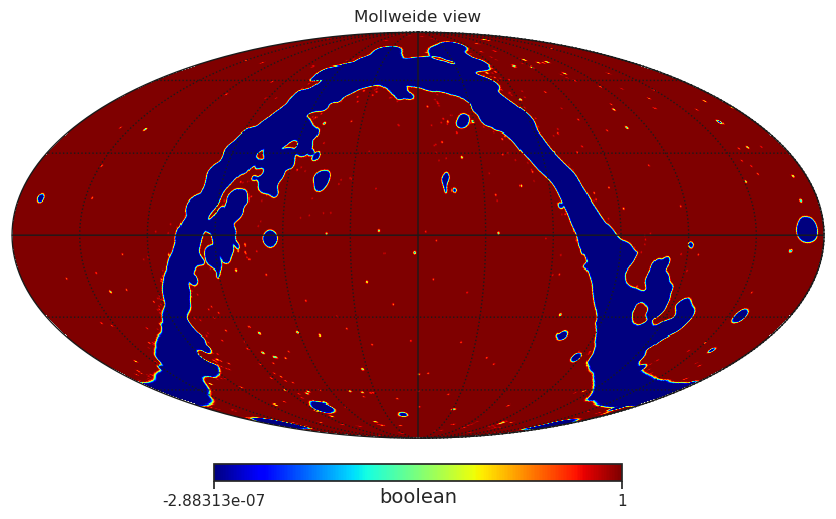

In [11]:
my_mollview(experiment.masks['t'], unit='boolean', fwhm=0.6)

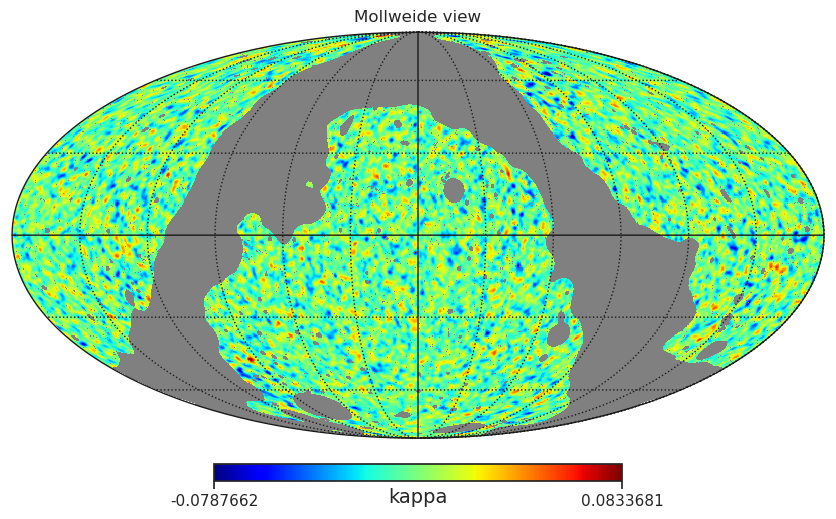

In [15]:
my_mollview(experiment.processed_maps['k'], unit='kappa', fwhm=1.6)

/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 20.383723 arcmin (0.005929 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/snakoneczny/tools/anaconda3/envs/py37_isw/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 48.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


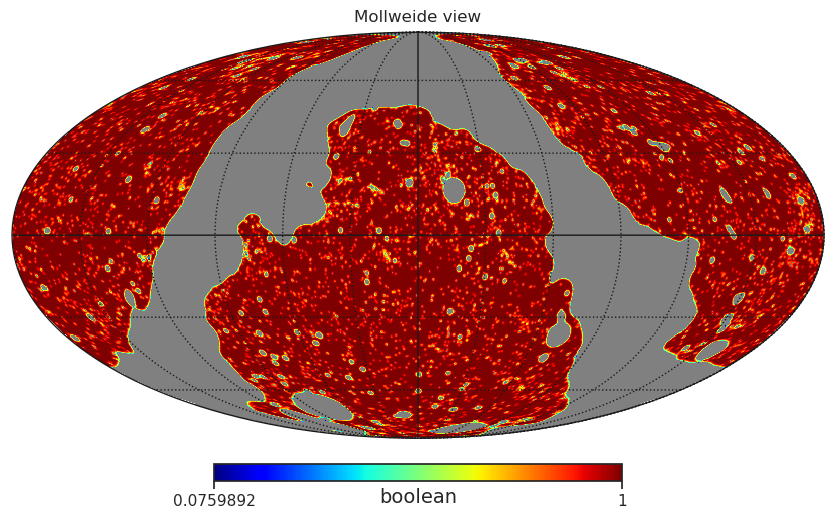

In [16]:
my_mollview(experiment.masks['k'], unit='boolean', fwhm=0.8)